# Telco Customer Churn Prediction with AutoGluon

이 노트북은 AutoGluon을 사용하여 통신사 고객 이탈을 예측하는 모델을 만듭니다.

**순서**
1. 컬럼별로 데이터 분석 및 시각화
2. 전처리
3. 특성 엔지니어링
4. 모델링
5. 앙상블
6. 모델 비교 평가
7. submission.csv 파일 생성

| 분류 | 고객 인구통계 및 결제 (Demographics & Billing) | 분류 | 서비스 가입 정보 (Services & Contract) |
| :--- | :--- | :--- | :--- |
| **customerID** | 고객 식별 번호 (ID) | **tenure** | 고객의 가입 기간 (개월 수) |
| **gender** | 성별 (Female, Male) | **PhoneService** | 전화 서비스 사용 여부 |
| **SeniorCitizen** | 고령자 여부 (0:젊은층, 1:고령자) | **MultipleLines** | 다중 회선 사용 여부 |
| **Partner** | 배우자 유무 (Yes, No) | **InternetService** | 인터넷 서비스 제공업체 종류 |
| **Dependents** | 부양가족 유무 (Yes, No) | **OnlineSecurity** | 온라인 보안 서비스 유무 |
| **PaperlessBilling** | 전자청구서 사용 여부 (Yes, No) | **OnlineBackup** | 온라인 백업 서비스 유무 |
| **PaymentMethod** | 결제 방법 (카드, 이체, 수표 등) | **DeviceProtection** | 기기 보호 서비스 유무 |
| **MonthlyCharges** | 월간 요금 (Monthly) | **TechSupport** | 기술 지원 서비스 유무 |
| **TotalCharges** | 총 누적 요금 (수치형 변환 필요) | **StreamingTV** | 스트리밍 TV 이용 유무 |
| **Churn** | **고객 이탈 여부 (Target: Yes/No)** | **StreamingMovies** | 스트리밍 영화 이용 유무 |
| **Contract** | **계약 기간 (1개월/1년/2년)** | | |

In [249]:
# 1. 라이브러리 임포트 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import os

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. 파일 존재 여부 먼저 확인
file_path = 'Telco-Customer-Churn.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ 데이터 로드 성공!")
    
    # 2. 'df'가 판다스 데이터프레임인지 확인
    if isinstance(df, pd.DataFrame):
        print("✅ df 변수가 데이터프레임으로 정상 선언되었습니다.")
        display(df.head())  # 이제 에러 없이 작동할 것입니다.
    else:
        print("❌ 변수 df가 데이터프레임이 아닙니다.")
else:
    print(f"❌ 에러: {file_path} 경로에 파일이 없습니다. 경로를 확인해주세요!")

✅ 데이터 로드 성공!
✅ df 변수가 데이터프레임으로 정상 선언되었습니다.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [250]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [251]:
# 데이터 전처리 전, TotalCharges의 빈 문자열 처리 필요
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\1319828881.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


# 2. 컬럼별 데이터 분석 및 시각화 (EDA)
데이터의 분포와 이탈률(Churn)과의 관계를 살펴봅니다.

In [252]:
# Churn을 수치형으로 변환 (시각화를 위해)
df['Churn_Numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [253]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


In [254]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\4195215460.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette=['#66b3ff','#fb8072'])


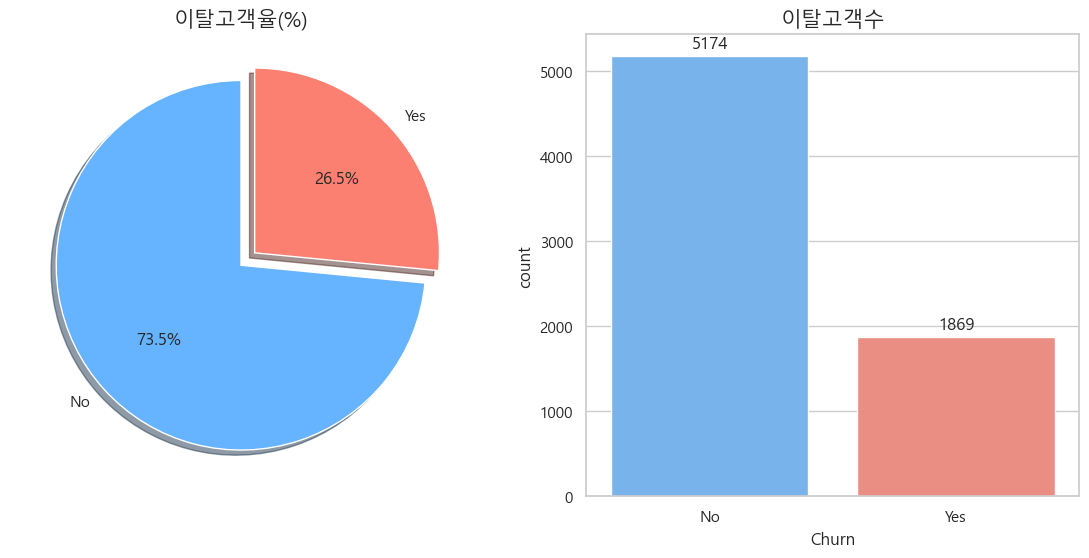

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
churn_counts = df['Churn'].value_counts()
labels = churn_counts.index # ['No', 'Yes']

# 2. 그래프 영역 설정 (1행 2열)
plt.figure(figsize=(14, 6))

# --- 좌측: 파이 차트 (비율 확인) ---
plt.subplot(1, 2, 1)
plt.pie(churn_counts, labels=labels, autopct='%.1f%%', startangle=90, 
        explode=[0, 0.1], colors=['#66b3ff','#fb8072'], shadow=True)
plt.title('이탈고객율(%)', fontsize=15)

# --- 우측: 카운트 플롯 (실제 인원수 확인) ---
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Churn', data=df, palette=['#66b3ff','#fb8072'])
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3) # 실제 명수 표시

plt.title('이탈고객수', fontsize=15)
plt.show()

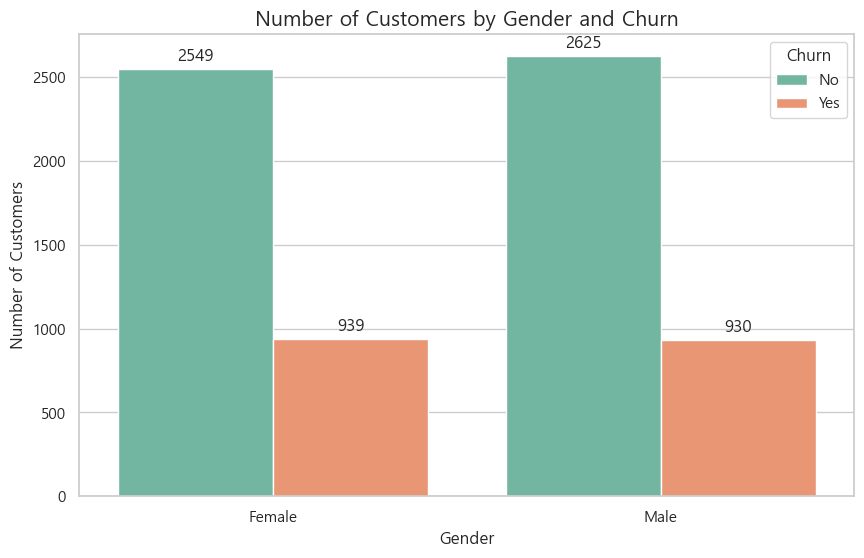

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'Churn_Numeric']

plt.figure(figsize=(10, 6))
# 1. countplot으로 성별별 이탈 여부 인원수 시각화
# x축은 성별, hue는 이탈 여부(Yes/No)
ax = sns.countplot(x='gender', hue='Churn', data=df, palette='Set2')

# 2. 막대 위에 인원수(Count) 레이블 추가
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

# 3. 그래프 꾸미기
plt.title('Number of Customers by Gender and Churn', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.legend(title='Churn', loc='upper right')
plt.show()

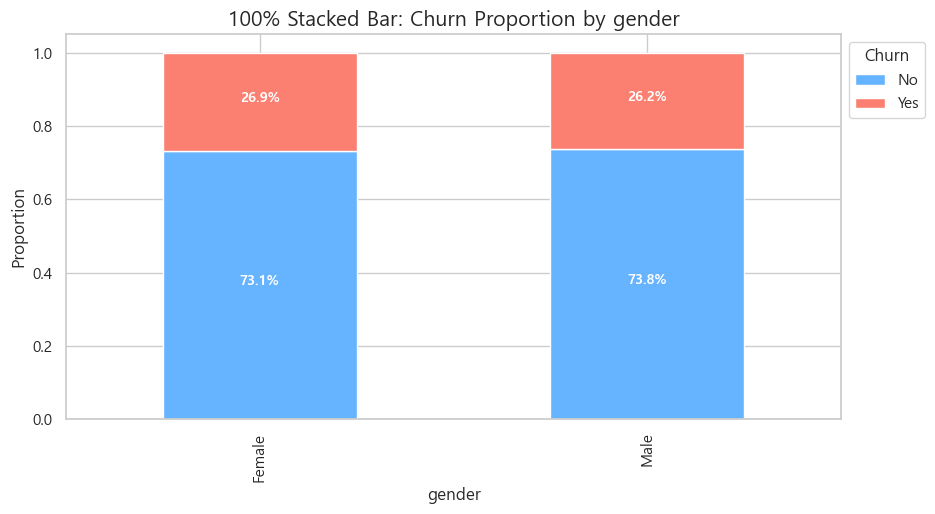

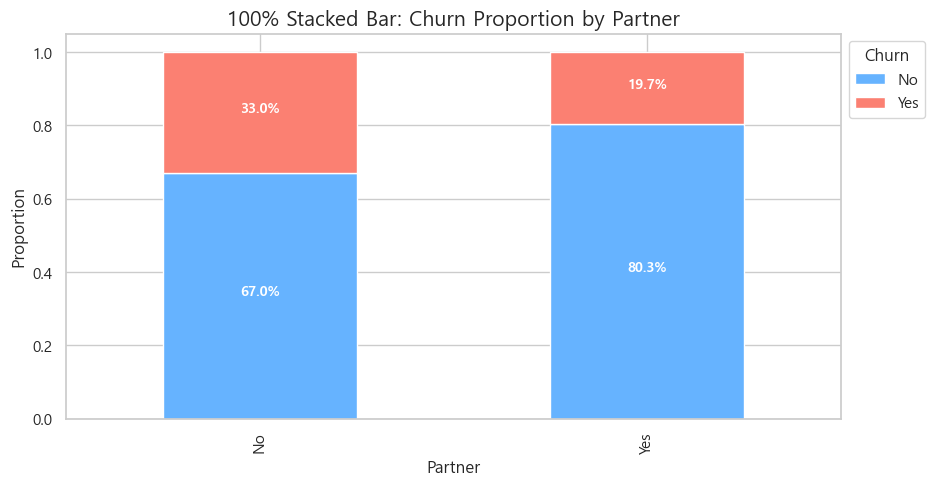

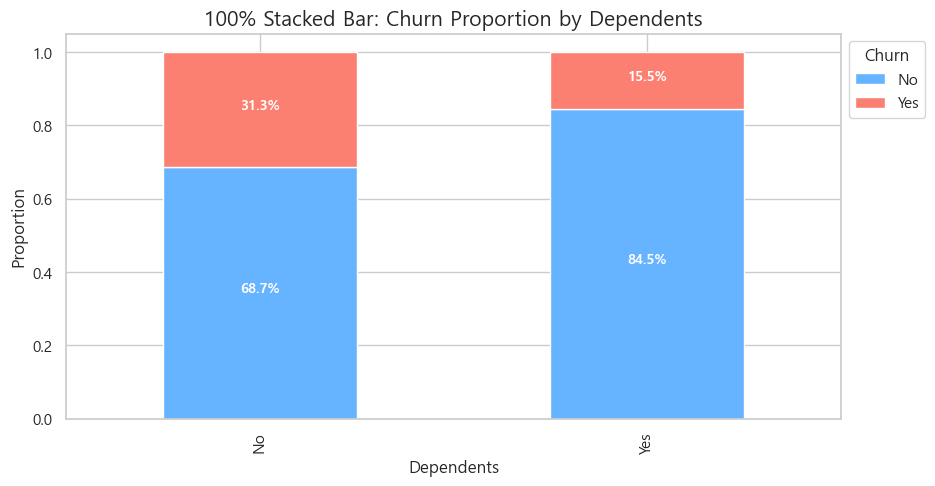

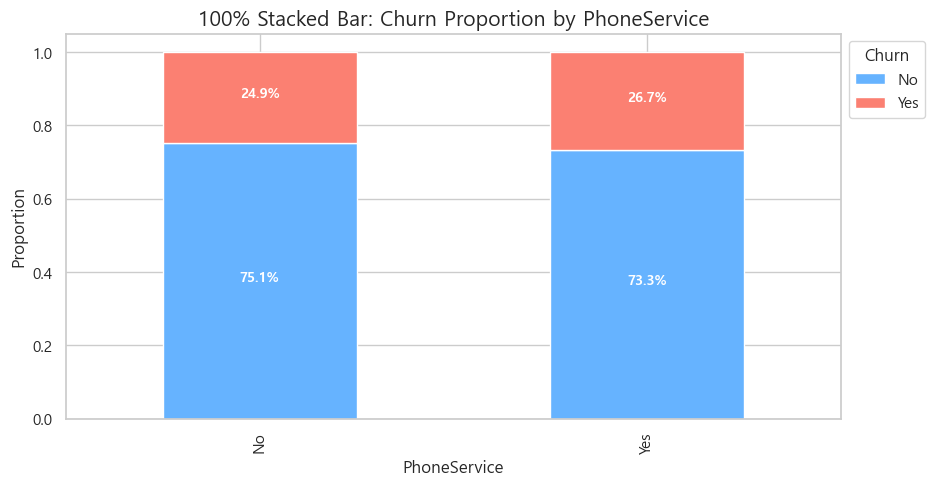

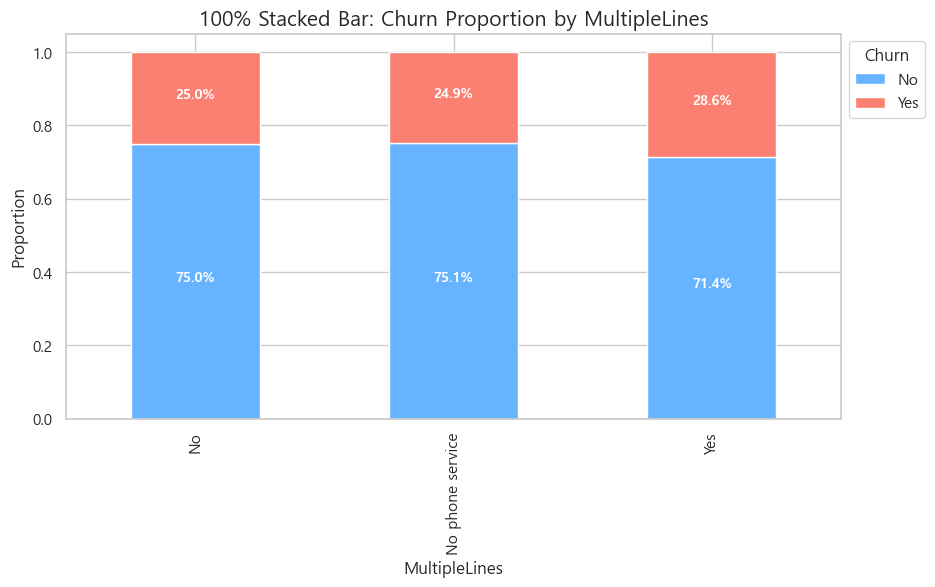

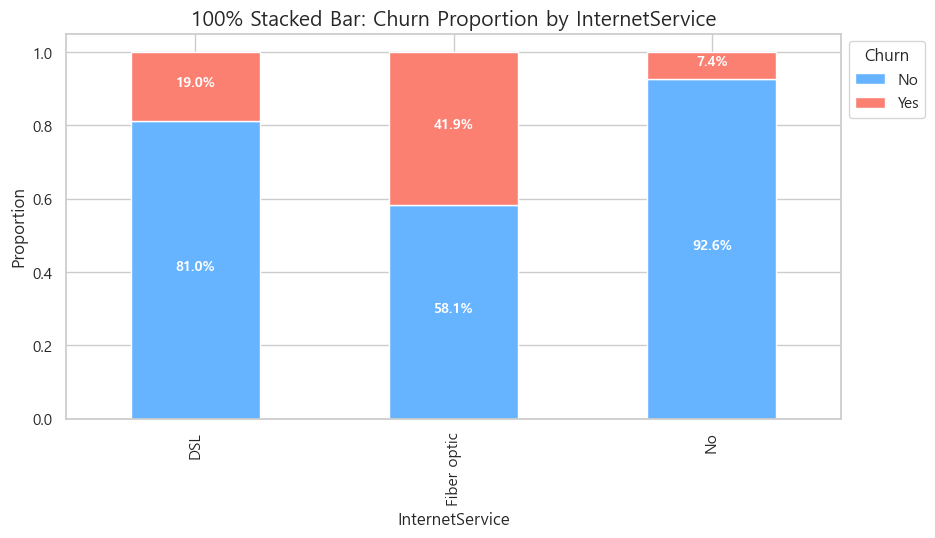

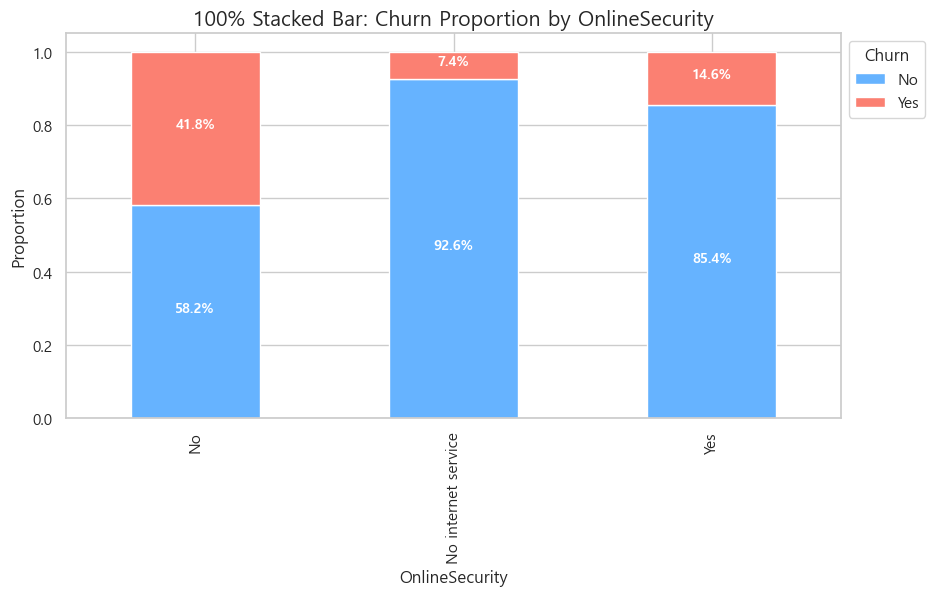

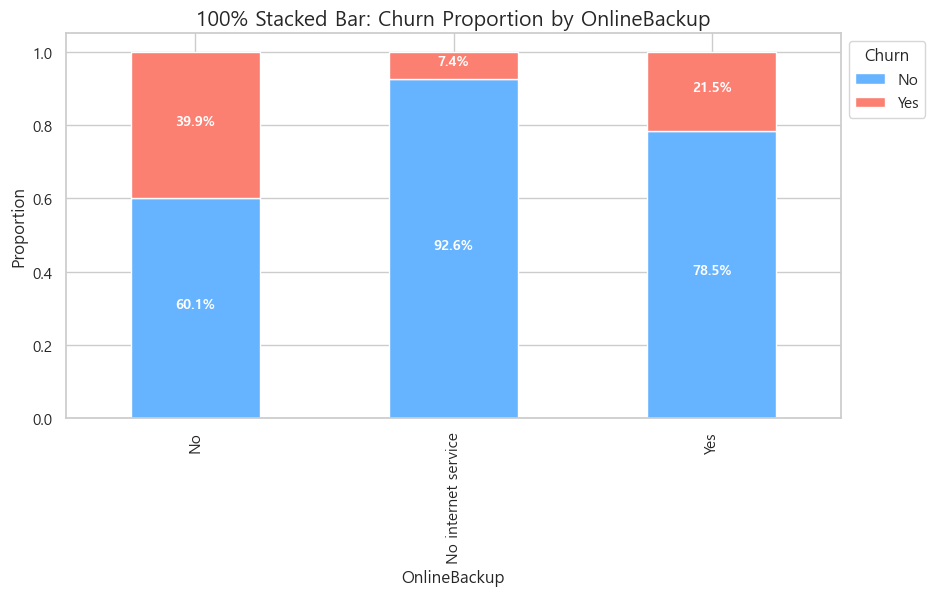

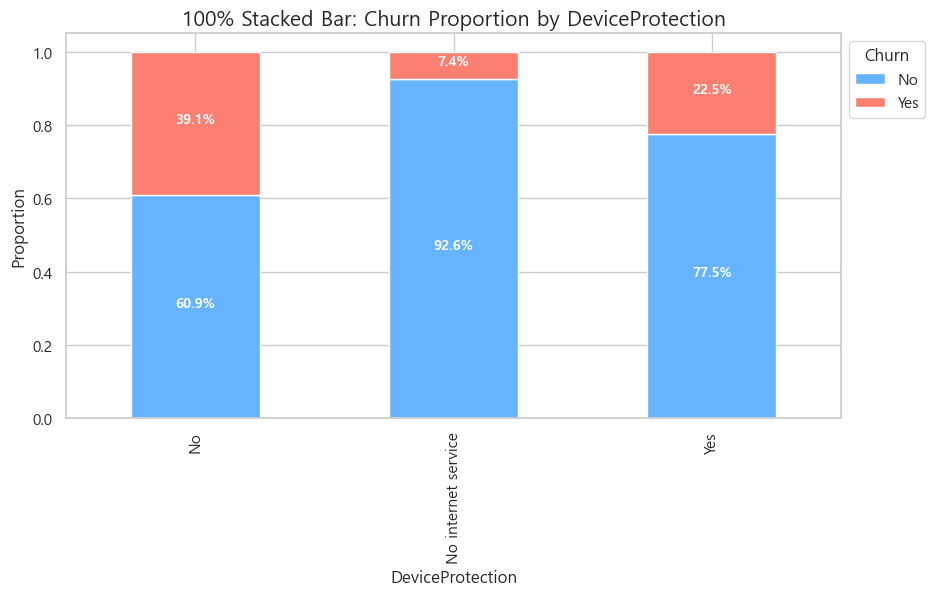

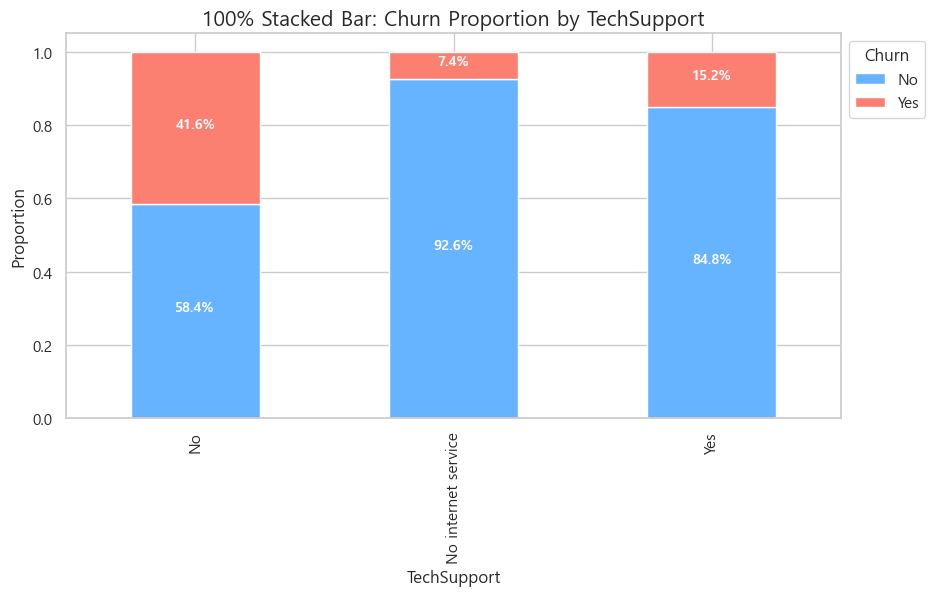

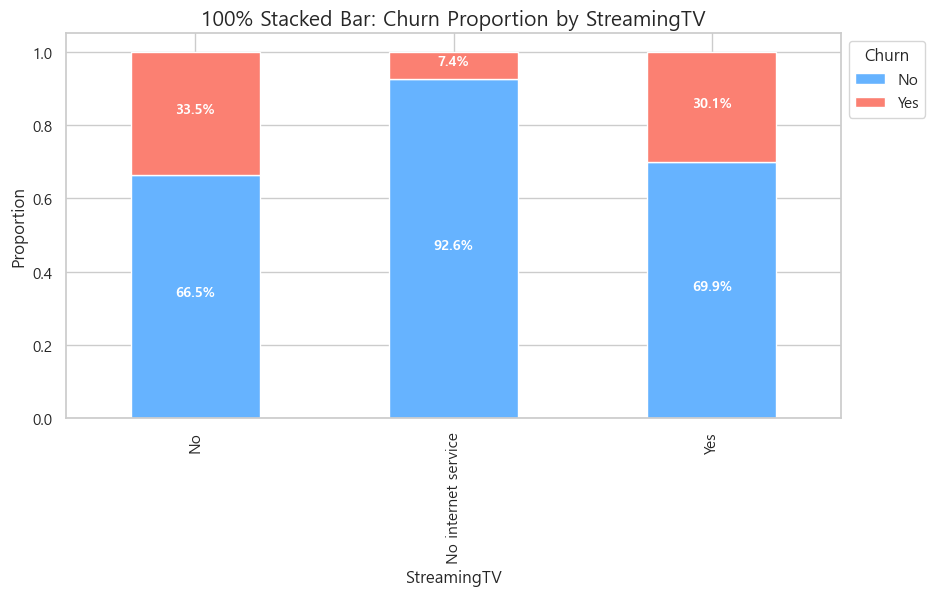

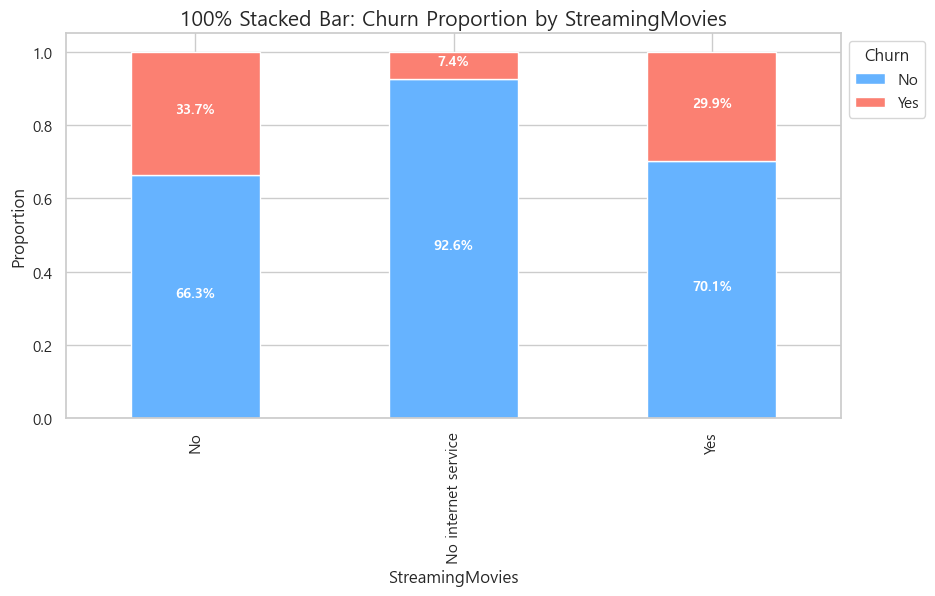

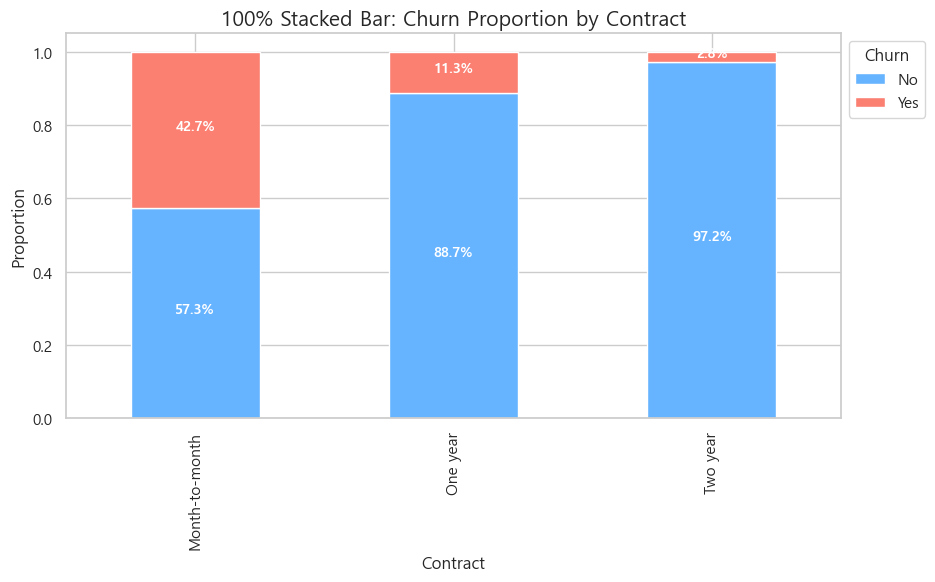

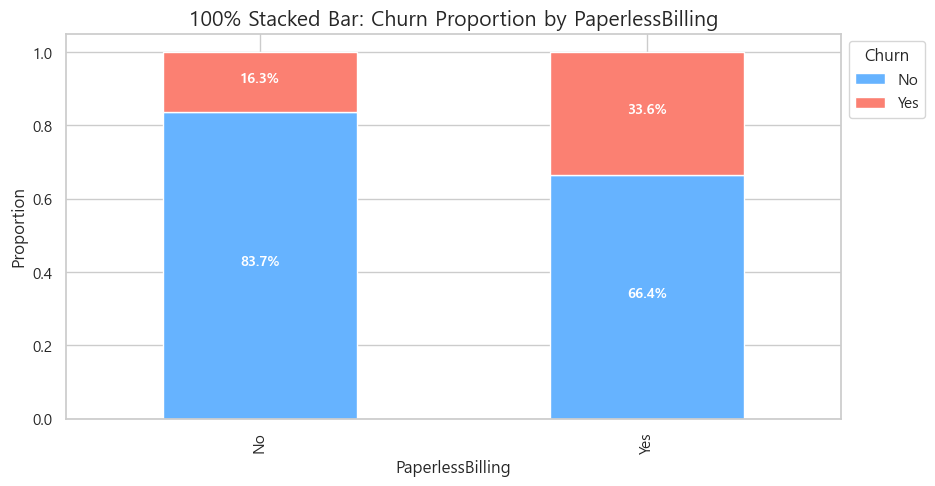

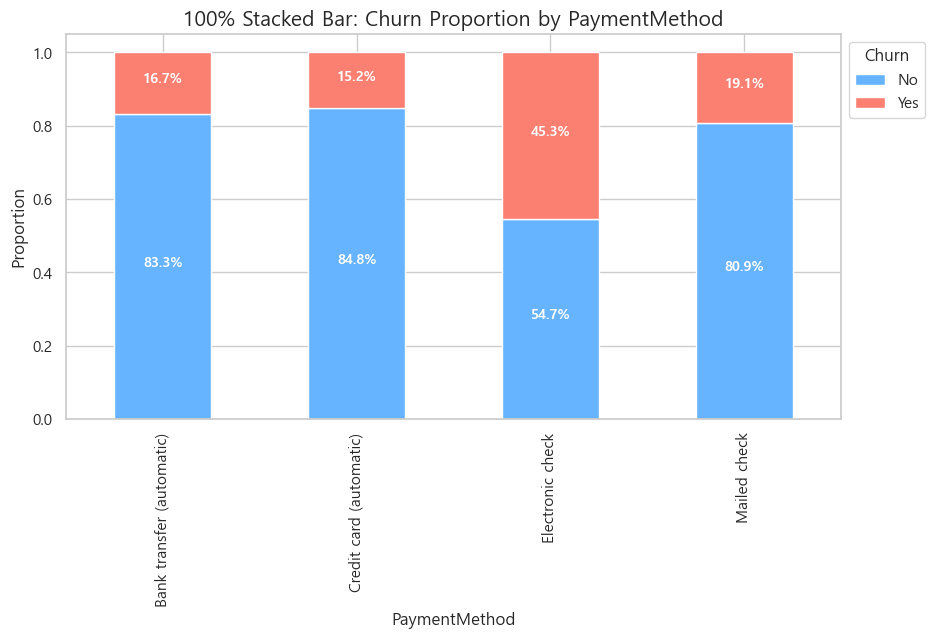

In [257]:

# 범주형 컬럼 리스트 생성 (ID와 타겟 제외)
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['customerID', 'Churn']]

for col in cat_cols:
    # 1. 교차표 생성 (인원수)
    cross_tab = pd.crosstab(df[col], df['Churn'])
    
    # 2. 행 단위로 합계가 1이 되도록 정규화 (전체를 100으로 설정)
    cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    
    # 3. 그래프 그리기
    ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(10, 5), color=['#66b3ff','#fb8072'])
    
    # 4. 막대 안에 비율(%) 표시하기
    for n, x in enumerate([*cross_tab_prop.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):
            plt.text(x=n,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{proportion*100:.1f}%', 
                     color="white",
                     fontsize=10,
                     fontweight="bold",
                     ha="center")

    plt.title(f'100% Stacked Bar: Churn Proportion by {col}', fontsize=15)
    plt.ylabel('Proportion')
    plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Numeric Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


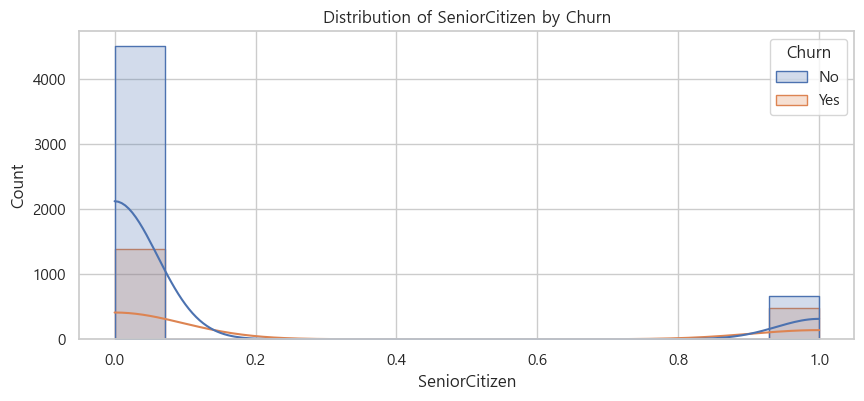

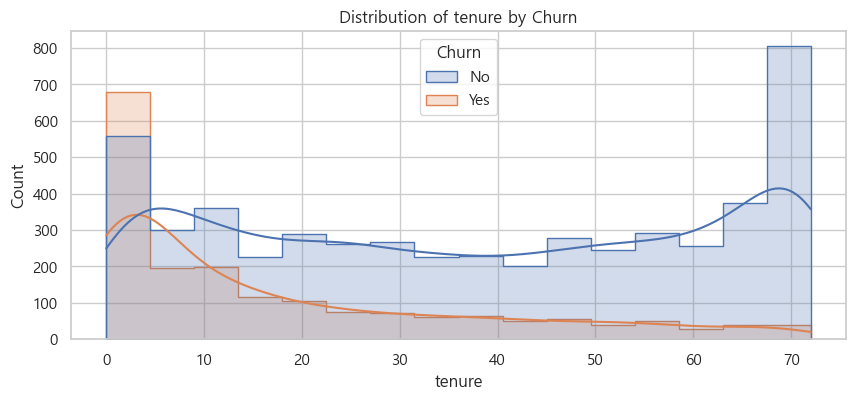

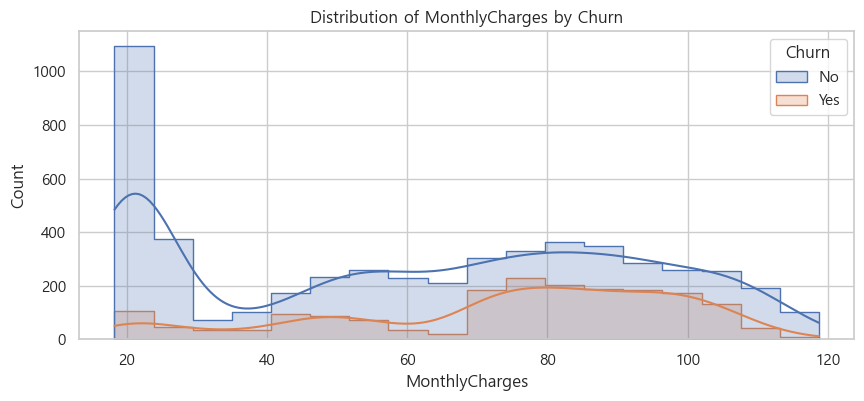

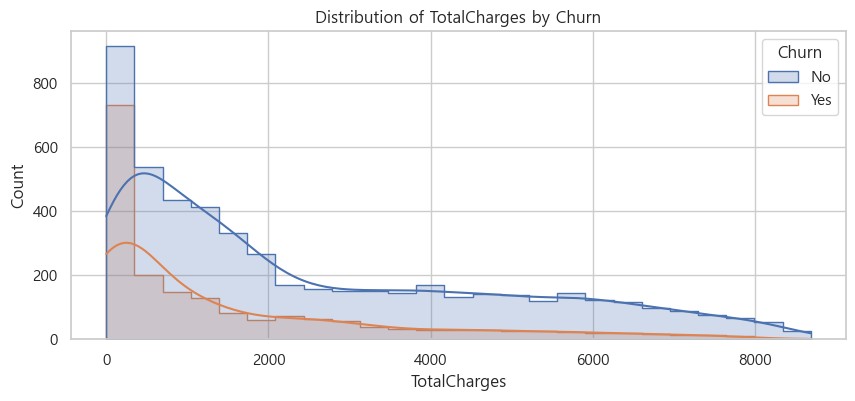

In [258]:


print("Numeric Columns:", num_cols)

# 수치형 데이터 시각화
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step")
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

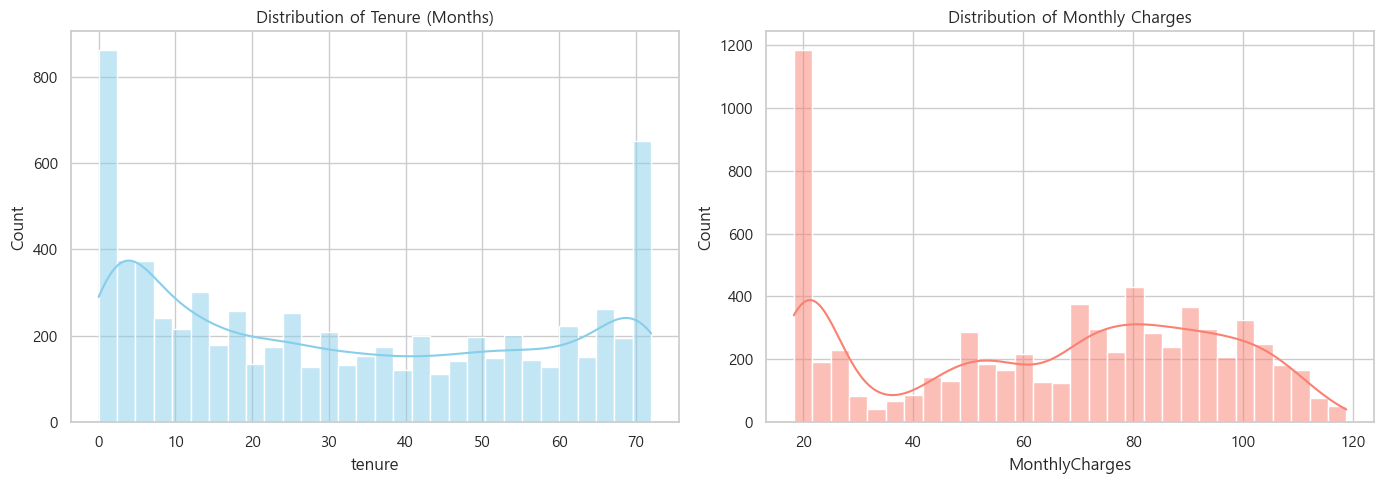

In [259]:
# 수치형 변수의 분포 및 구간화를 히스토그램으로 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# tenure 분포
sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Tenure (Months)')

# MonthlyCharges 분포
sns.histplot(df['MonthlyCharges'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Monthly Charges')

plt.tight_layout()
plt.show()


C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\3048791458.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='Churn_binary', data=df, palette='muted', errorbar=None)


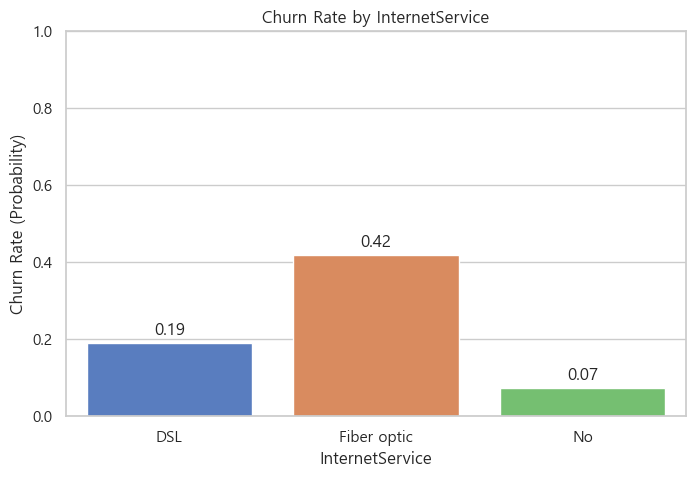

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\3048791458.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='Churn_binary', data=df, palette='muted', errorbar=None)


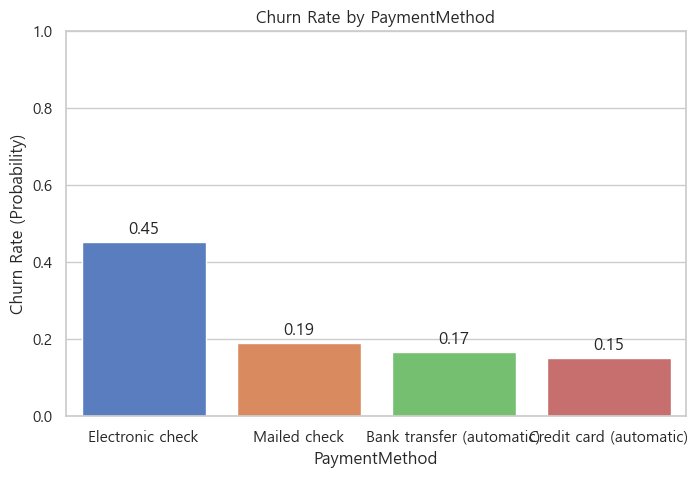

In [260]:
# 카테고리별 '이탈률(Churn Rate)' 시각화
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --- 2. 이탈률 시각화 함수 정의 ---
def plot_churn_rate(column_name):
    plt.figure(figsize=(8, 5))
    
    # barplot은 기본적으로 y값의 '평균'을 계산해줍니다. 
    # 0과 1의 평균 = 이탈률(Probability)이 되므로 아주 유용합니다.
    sns.barplot(x=column_name, y='Churn_binary', data=df, palette='muted', errorbar=None)
    
    plt.title(f'Churn Rate by {column_name}')
    plt.ylabel('Churn Rate (Probability)')
    plt.ylim(0, 1) # 0% ~ 100% 범위 고정
    
    # 막대 위에 수치 표시 (Optional)
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), textcoords = 'offset points')
    plt.show()

# --- 3. 주요 변수 확인 ---
plot_churn_rate('InternetService') # Fiber optic의 이탈률이 높은지 확인
plot_churn_rate('PaymentMethod')   # Electronic check의 이탈률 확인

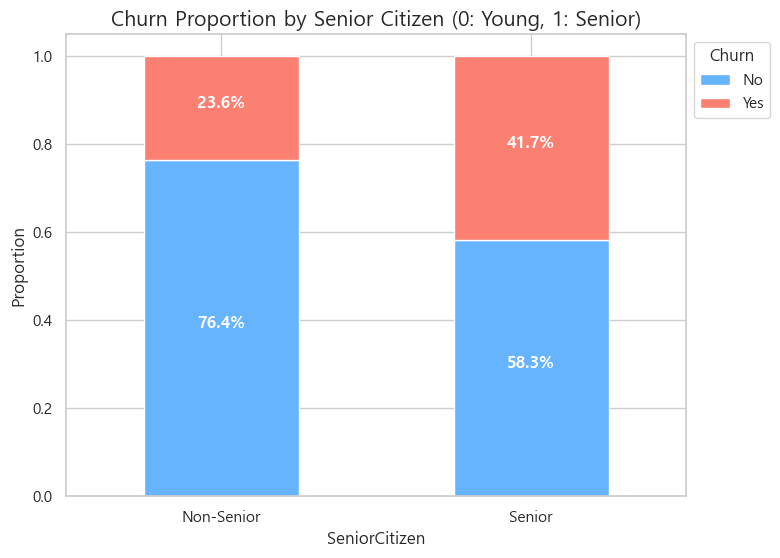

In [261]:
# 1. 교차표 생성 (0: 젊은 층, 1: 고령자)
cross_tab = pd.crosstab(df['SeniorCitizen'], df['Churn'])

# 2. 비율로 변환 (전체 합을 100%로 설정)
cross_tab_prop = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)

# 3. 그래프 그리기
ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff','#fb8072'])

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*cross_tab_prop.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
        plt.text(x=n,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="white",
                 fontsize=12,
                 fontweight="bold",
                 ha="center")

plt.title('Churn Proportion by Senior Citizen (0: Young, 1: Senior)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0) # 라벨을 보기 쉽게 변경
plt.ylabel('Proportion')
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

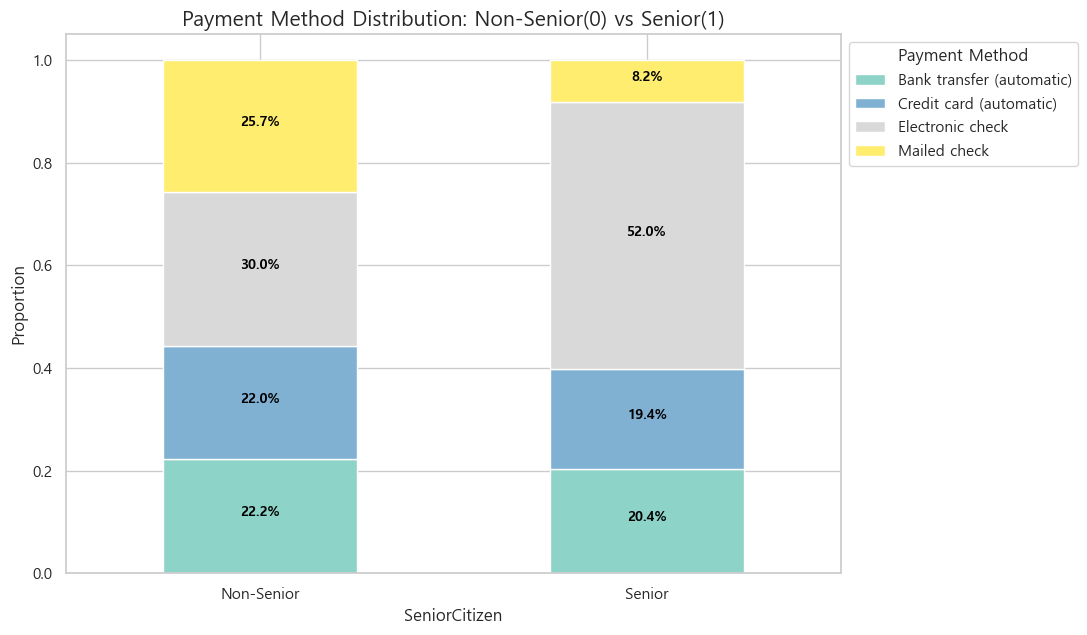

In [262]:
# 1. SeniorCitizen과 PaymentMethod의 교차표 생성
senior_payment = pd.crosstab(df['SeniorCitizen'], df['PaymentMethod'])

# 2. 비율로 변환 (각 그룹 내에서 어떤 결제수단을 많이 쓰는지)
senior_payment_prop = senior_payment.div(senior_payment.sum(1).astype(float), axis=0)

# 3. 시각화
ax = senior_payment_prop.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Set3')

# 4. 막대 안에 비율(%) 표시
for n, x in enumerate([*senior_payment_prop.index.values]):
    cumulative_height = 0
    for col in senior_payment_prop.columns:
        proportion = senior_payment_prop.loc[x, col]
        plt.text(x=n,
                 y=cumulative_height + (proportion / 2),
                 s=f'{proportion*100:.1f}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold",
                 ha="center")
        cumulative_height += proportion

plt.title('Payment Method Distribution: Non-Senior(0) vs Senior(1)', fontsize=15)
plt.xticks([0, 1], ['Non-Senior', 'Senior'], rotation=0)
plt.ylabel('Proportion')
plt.legend(title='Payment Method', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\531965128.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\531965128.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen',
C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전
C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\531965128.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

<Figure size 1200x600 with 0 Axes>

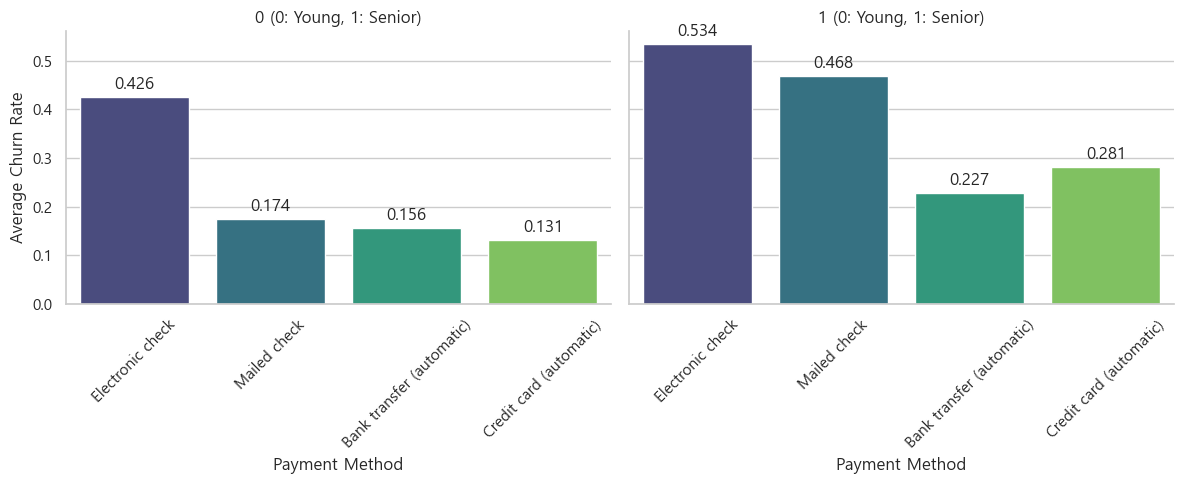

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고령자 여부에 따른 결제 수단별 이탈률 시각화
plt.figure(figsize=(12, 6))

# catplot은 여러 개의 그래프를 나란히 그리기에 아주 좋습니다.
g = sns.catplot(x='PaymentMethod', y='Churn_Numeric', col='SeniorCitizen', 
                data=df, kind='bar', palette='viridis', ci=None, height=5, aspect=1.2)

# 각 막대 위에 수치(이탈률) 표시
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # 라벨 회전

g.set_axis_labels("Payment Method", "Average Churn Rate")
g.set_titles("{col_name} (0: Young, 1: Senior)")
plt.tight_layout()
plt.show()

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\2817978305.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Contract', data=senior_df, palette='magma', order=['Month-to-month', 'One year', 'Two year'])


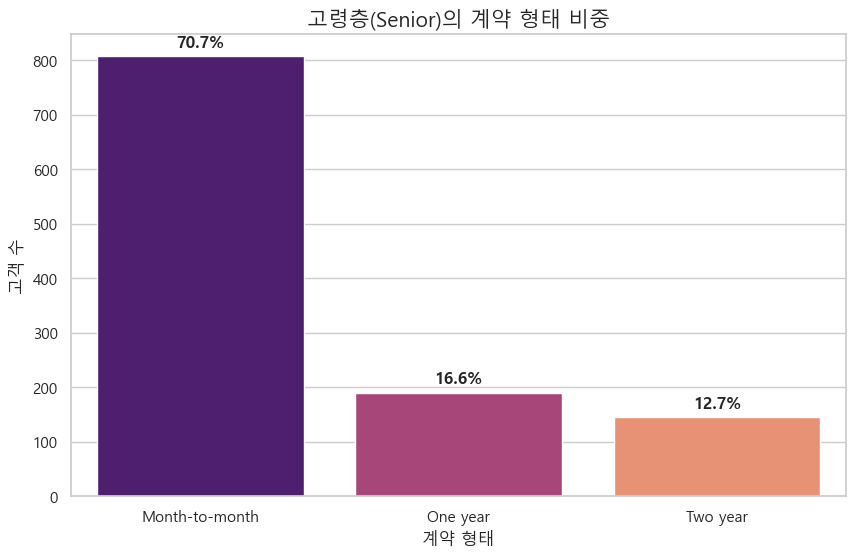

--- 고령층 계약 형태 상세 비율 ---
Contract
Month-to-month    70.665499
One year          16.637478
Two year          12.697023
Name: proportion, dtype: float64


In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 고령자 데이터만 추출
senior_df = df[df['SeniorCitizen'] == 1]

# 2. 고령자 내 계약 형태 비율 계산
contract_counts = senior_df['Contract'].value_counts(normalize=True) * 100

# 3. 시각화 (파이 차트 또는 막대 그래프)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Contract', data=senior_df, palette='magma', order=['Month-to-month', 'One year', 'Two year'])

# 막대 위에 백분율 표시
total = len(senior_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.title('고령층(Senior)의 계약 형태 비중', fontsize=15)
plt.ylabel('고객 수')
plt.xlabel('계약 형태')
plt.show()

print("--- 고령층 계약 형태 상세 비율 ---")
print(contract_counts)

시니어(1) 및 비시니어(0)의 계약별 이탈률(%):


Churn                                No        Yes
SeniorCitizen Contract                            
0             Month-to-month  60.430248  39.569752
              One year        89.321902  10.678098
              Two year        97.290323   2.709677
1             Month-to-month  45.353160  54.646840
              One year        84.736842  15.263158
              Two year        95.862069   4.137931

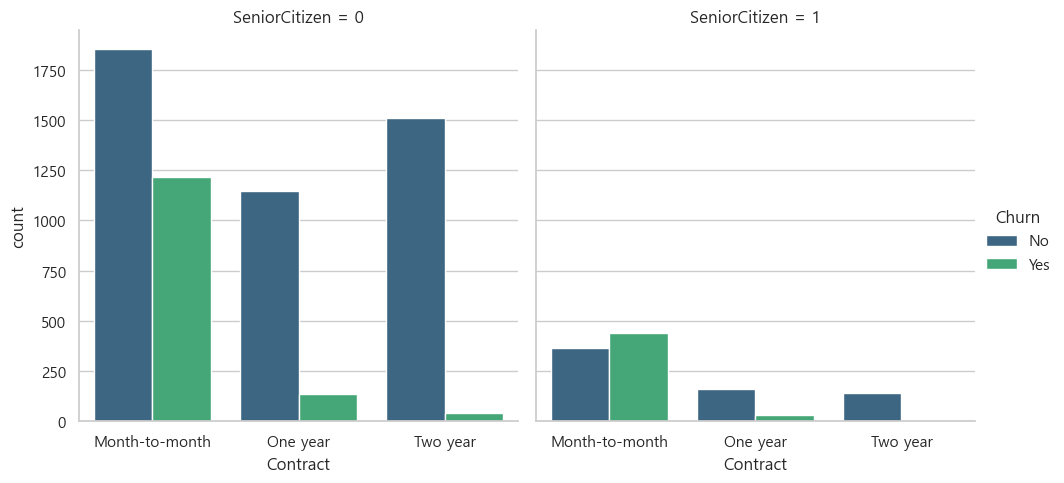

In [265]:
# 시니어 여부에 따른 계약 형태별 이탈률 교차 분석
senior_contract_churn = df.groupby(['SeniorCitizen', 'Contract'])['Churn'].value_counts(normalize=True).unstack() * 100

print("시니어(1) 및 비시니어(0)의 계약별 이탈률(%):")
display(senior_contract_churn)

# 시각화: 시니어 고객 중 'Month-to-month' 계약자의 이탈 비중 확인
sns.catplot(x='Contract', hue='Churn', col='SeniorCitizen', 
            data=df, kind='count', palette='viridis')

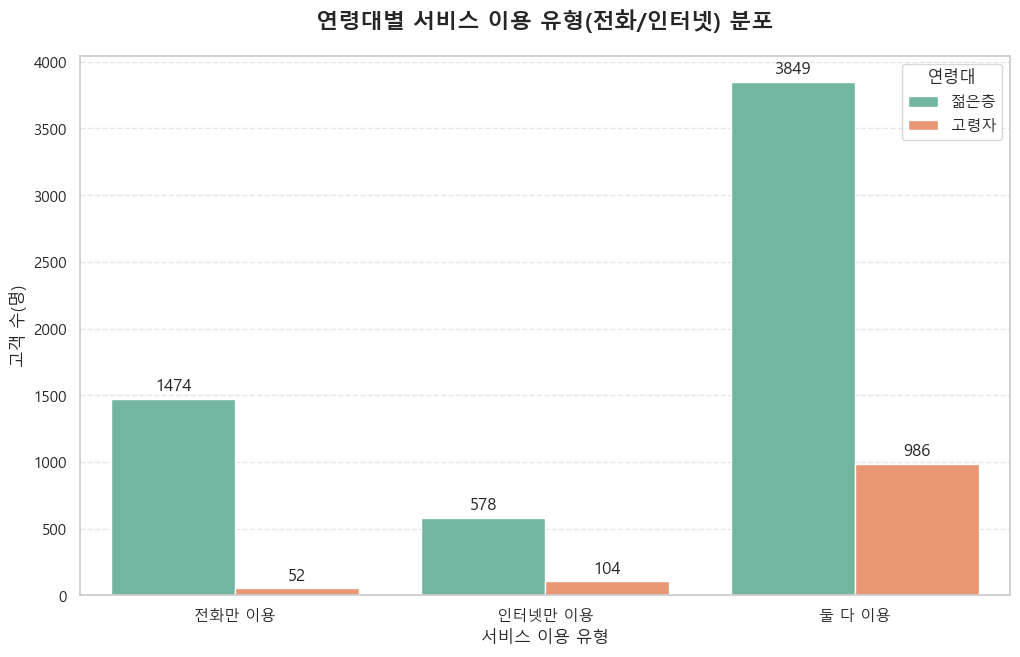

--- 연령대별 서비스 이용 유형 비율 (%) ---
ServiceType     둘 다 이용  인터넷만 이용     전화만 이용
연령대                                       
고령자          86.339755  9.10683   4.553415
젊은층          65.226233  9.79495  24.978817


In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 서비스 이용 유형 분류 함수 정의
def classify_service(row):
    has_phone = (row['PhoneService'] == 'Yes')
    has_internet = (row['InternetService'] != 'No')
    
    if has_phone and has_internet:
        return '둘 다 이용'
    elif has_phone:
        return '전화만 이용'
    elif has_internet:
        return '인터넷만 이용'
    else:
        return '둘 다 미이용'

# 2. 데이터 적용 및 연령대 라벨링
df_combo = df.copy()
df_combo['ServiceType'] = df_combo.apply(classify_service, axis=1)
df_combo['연령대'] = df_combo['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})

# 3. 시각화 (연령대별 서비스 유형 비중)
plt.figure(figsize=(12, 7))

# 전체적인 규모와 연령대별 차이를 동시에 보기 위해 countplot 사용
ax = sns.countplot(data=df_combo, x='ServiceType', hue='연령대', 
                   order=['전화만 이용', '인터넷만 이용', '둘 다 이용'],
                   palette='Set2')

# 막대 위에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('연령대별 서비스 이용 유형(전화/인터넷) 분포', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('서비스 이용 유형', fontsize=12)
plt.ylabel('고객 수(명)', fontsize=12)
plt.legend(title='연령대')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 4. 수치로도 확인 (비율)
print("--- 연령대별 서비스 이용 유형 비율 (%) ---")
print(pd.crosstab(df_combo['연령대'], df_combo['ServiceType'], normalize='index') * 100)

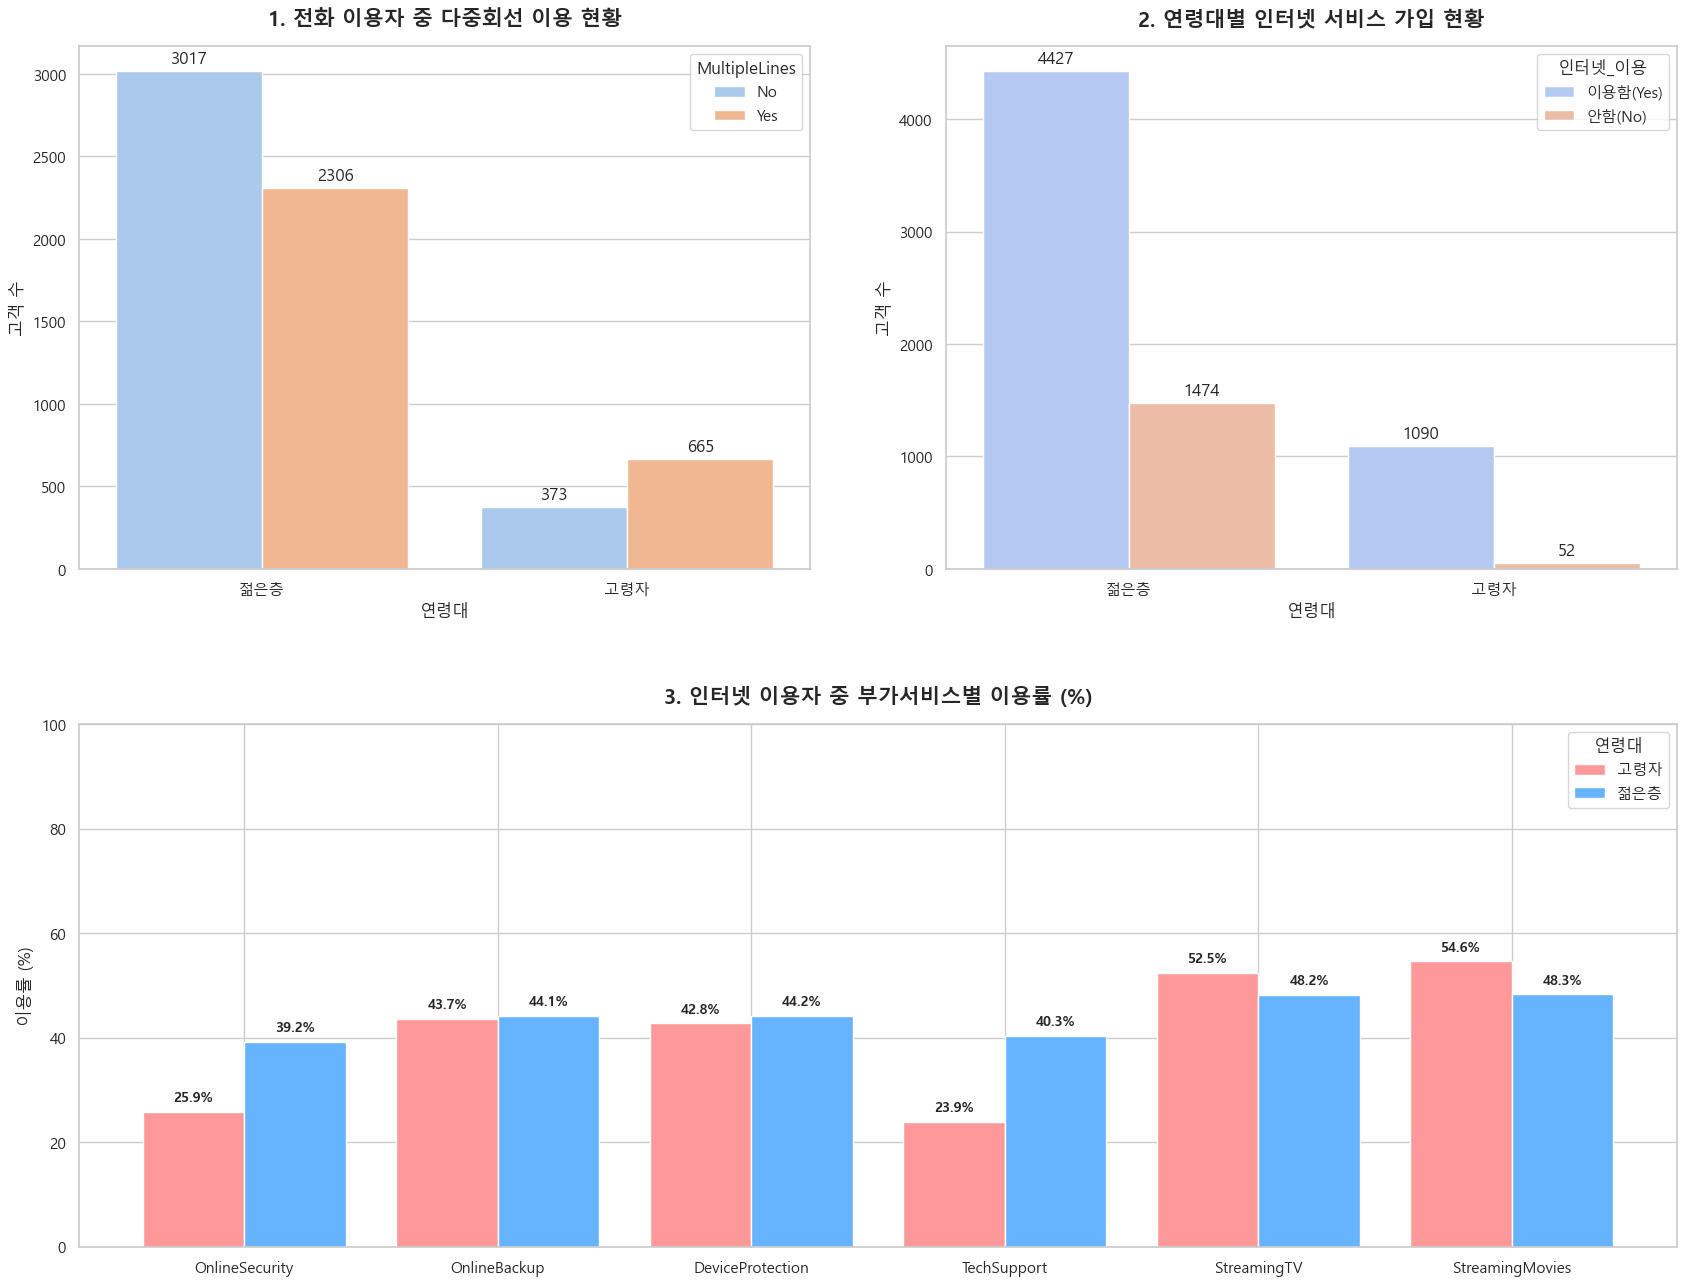

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 데이터 준비
df_plot = df.copy()
df_plot['연령대'] = df_plot['SeniorCitizen'].replace({0: '젊은층', 1: '고령자'})
df_plot['인터넷_이용'] = df_plot['InternetService'].apply(lambda x: '안함(No)' if x == 'No' else '이용함(Yes)')

# 2. 캔버스 설정 (2행 2열 구조, 3번 그래프는 아래쪽 전체 사용)
fig = plt.figure(figsize=(18, 14))
ax1 = plt.subplot(2, 2, 1) # 1행 1열: 전화
ax2 = plt.subplot(2, 2, 2) # 1행 2열: 인터넷 가입
ax3 = plt.subplot(2, 1, 2) # 2행 전체: 인터넷 부가서비스

# --- [그래프 1: 전화 이용자 내 다중회선 현황] ---
phone_users = df_plot[df_plot['PhoneService'] == 'Yes']
sns.countplot(data=phone_users, x='연령대', hue='MultipleLines', ax=ax1, palette='pastel')
ax1.set_title('1. 전화 이용자 중 다중회선 이용 현황', fontsize=15, fontweight='bold', pad=15)
ax1.set_ylabel('고객 수')
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', padding=3)

# --- [그래프 2: 연령대별 인터넷 서비스 가입 현황] ---
sns.countplot(data=df_plot, x='연령대', hue='인터넷_이용', ax=ax2, palette='coolwarm')
ax2.set_title('2. 연령대별 인터넷 서비스 가입 현황', fontsize=15, fontweight='bold', pad=15)
ax2.set_ylabel('고객 수')
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', padding=3)

# --- [그래프 3: 인터넷 이용자 내 부가서비스 이용률 (아래쪽)] ---
it_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_users = df_plot[df_plot['InternetService'] != 'No']
it_usage = internet_users.groupby('연령대')[it_services].apply(lambda x: (x == 'Yes').mean() * 100).T

it_usage.plot(kind='bar', ax=ax3, color=['#ff9999', '#66b3ff'], width=0.8)
ax3.set_title('3. 인터넷 이용자 중 부가서비스별 이용률 (%)', fontsize=15, fontweight='bold', pad=15)
ax3.set_ylabel('이용률 (%)')
ax3.set_ylim(0, 100)
ax3.legend(title='연령대', loc='upper right')
plt.xticks(rotation=0) # 라벨 가독성을 위해 회전 고정

# 수치 표시
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10, fontweight='bold')

plt.tight_layout(pad=4.0)
plt.show()

In [268]:
# 인터넷을 이용하지 않는 사람(No) 중 부가서비스를 하나라도 'Yes'로 가진 사람 찾기
it_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# 인터넷 미이용자 필터링
no_internet = df[df['InternetService'] == 'No']

# 부가서비스 중 하나라도 'Yes'인 경우를 합산
error_data = no_internet[(no_internet[it_services] == 'Yes').any(axis=1)]

print(f"인터넷 미이용자 중 부가서비스 이용자 수: {len(error_data)}명")

if len(error_data) == 0:
    print("✅ 데이터가 논리적으로 완벽합니다! 인터넷 없이 부가서비스를 쓰는 사람은 없습니다.")
else:
    print("⚠️ 데이터에 오류가 있습니다. 확인이 필요합니다.")

인터넷 미이용자 중 부가서비스 이용자 수: 0명
✅ 데이터가 논리적으로 완벽합니다! 인터넷 없이 부가서비스를 쓰는 사람은 없습니다.


In [269]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric,Churn_binary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,1


# 3. 데이터 전처리 (Preprocessing)
- 불필요한 컬럼 제거 (`customerID`, 시각화용 `Churn_Numeric`)
- 결측치 처리 (이미 위에서 수행함)

In [282]:
# 불필요한 컬럼 제거
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

if 'Churn_Numeric' in df.columns:
    df = df.drop('Churn_Numeric', axis=1)

# 결측치 재확인
print(df.isnull().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Churn                0
Churn_binary         0
TenureGroup          0
ServiceCount         0
TotalServiceCount    0
FamilyType           0
dtype: int64


# 4. 특성 엔지니어링 (Feature Engineering)
- `TenureGroup`: 가입 기간을 그룹화
- `ServicesCount`: 가입한 부가 서비스 수
- `ContractType`: 계약 형태 단순화 (선택 사항)

In [271]:
# 1년 단위로 촘촘하게 다시 그룹화
def tenure_group_refined(tenure):
    if tenure <= 12:
        return '1년 이하'
    elif tenure <= 24:
        return '2년 이하'
    elif tenure <= 36:
        return '3년 이하'
    elif tenure <= 48:
        return '4년 이하'
    elif tenure <= 60:
        return '5년 이하'
    else:
        return '5년 초과'

df['TenureGroup'] = df['tenure'].apply(tenure_group_refined)

# 순서 고정을 위한 리스트 (그래프 그릴 때 사용)
order_list = ['1년 이하', '2년 이하', '3년 이하', '4년 이하', '5년 이하', '5년 초과']

display(df[['tenure', 'TenureGroup']].head())

,tenure,TenureGroup
0,1,1년 이하
1,34,3년 이하
2,2,1년 이하
3,45,4년 이하
4,2,1년 이하


In [272]:
# 1. 조건에 맞는 데이터 필터링 (InternetService가 'No'이면서 PhoneService가 'Yes')
only_phone_customers = df[(df['InternetService'] == 'No') & (df['PhoneService'] == 'Yes')]

# 2. 해당 고객 수 출력
print(f"인터넷 없이 전화만 사용하는 고객 수: {len(only_phone_customers)}명")

# 3. 데이터 상단 확인
only_phone_customers.head()

인터넷 없이 전화만 사용하는 고객 수: 1526명


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric,Churn_binary,TenureGroup
11,7469-LKBCI,Male,0,No,No,16,Yes,No,No,No internet service,...,No internet service,Two year,No,Credit card (automatic),18.95,326.80,No,0,0,2년 이하
16,8191-XWSZG,Female,0,No,No,52,Yes,No,No,No internet service,...,No internet service,One year,No,Mailed check,20.65,1022.95,No,0,0,5년 이하
21,1680-VDCWW,Male,0,Yes,No,12,Yes,No,No,No internet service,...,No internet service,One year,No,Bank transfer (automatic),19.80,202.25,No,0,0,1년 이하
22,1066-JKSGK,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes,1,1,1년 이하
33,7310-EGVHZ,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,Month-to-month,No,Bank transfer (automatic),20.20,20.20,No,0,0,1년 이하


In [273]:
# 1. PhoneService가 No인데 MultipleLines가 Yes인 모순된 데이터 찾기
issue_customers = df[(df['PhoneService'] == 'No') & (df['MultipleLines'] == 'Yes')]

# 2. 결과 출력
print(f"모순된 데이터 건수: {len(issue_customers)}건")

# 3. 만약 있다면 데이터 확인
if len(issue_customers) > 0:
    print(issue_customers[['PhoneService', 'MultipleLines']])
else:
    print("데이터에 모순이 없습니다. (PhoneService가 No인 경우 MultipleLines는 모두 No 또는 No phone service입니다.)")

모순된 데이터 건수: 0건
데이터에 모순이 없습니다. (PhoneService가 No인 경우 MultipleLines는 모두 No 또는 No phone service입니다.)


C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\532139121.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)
C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\532139121.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)


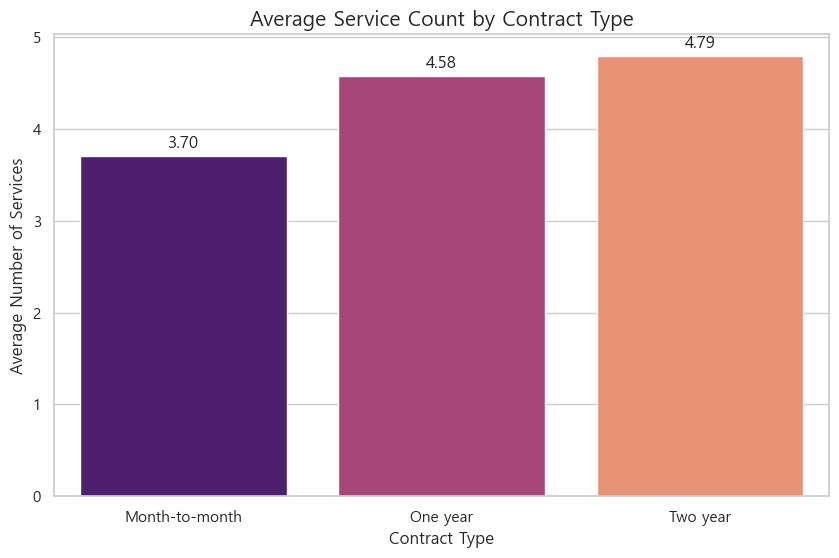

In [274]:
# 1. 서비스 관련 컬럼 리스트 (인터넷 서비스 자체와 부가 서비스들)
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# 2. 'Yes'인 경우를 1로 계산하여 합산 (InternetService는 'No'가 아니면 이용 중으로 간주할 수 있음)
df['ServiceCount'] = (df[service_cols] == 'Yes').sum(axis=1)
# InternetService가 'No'가 아닌 경우도 하나의 서비스로 추가
df['ServiceCount'] += (df['InternetService'] != 'No').astype(int)

# 3. 계약기간(Contract)별 서비스카운트(ServiceCount) 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Contract', y='ServiceCount', data=df, palette='magma', ci=None)

# 막대 위에 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Average Service Count by Contract Type', fontsize=15)
plt.ylabel('Average Number of Services')
plt.xlabel('Contract Type')
plt.show()

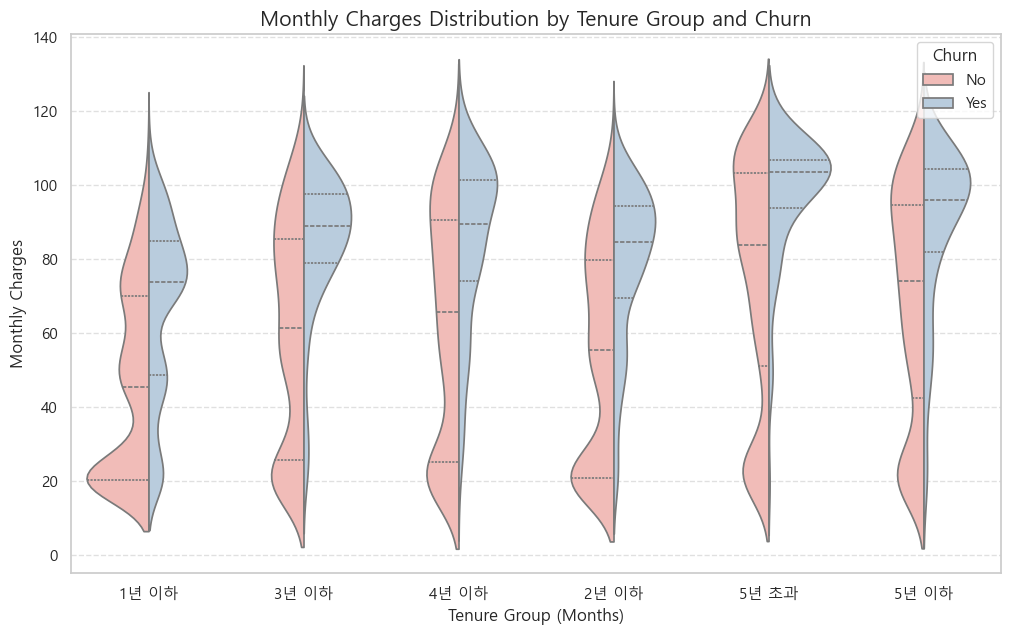

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# 가입 기간 그룹(TenureGroup)별로 MonthlyCharges와 이탈 여부를 시각화
plt.figure(figsize=(12, 7))

# 바이올린 플롯으로 요금 분포 확인
sns.violinplot(x='TenureGroup', y='MonthlyCharges', hue='Churn', 
               data=df, split=True, palette='Pastel1', inner="quartile")

plt.title('Monthly Charges Distribution by Tenure Group and Churn', fontsize=15)
plt.xlabel('Tenure Group (Months)')
plt.ylabel('Monthly Charges')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Churn', loc='upper right')
plt.show()

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\1235657672.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=overall_service_churn, palette='coolwarm')


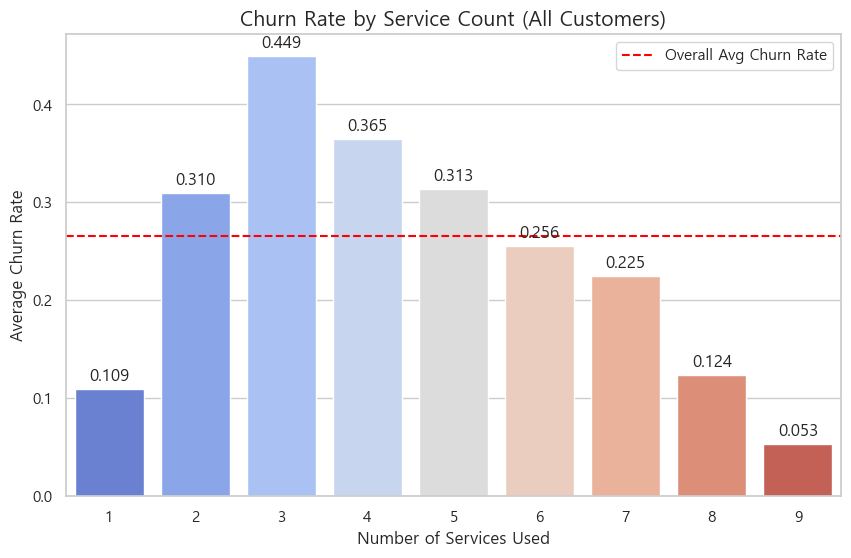

In [276]:
# 1. 전체 고객 대상 서비스 개수별 이탈률 계산
overall_service_churn = df.groupby('ServiceCount')['Churn_Numeric'].mean().reset_index()

# 2. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=overall_service_churn, palette='coolwarm')

# 막대 위에 이탈률 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

# 전체 평균 이탈률 선 표시
plt.axhline(df['Churn_Numeric'].mean(), color='red', linestyle='--', label='Overall Avg Churn Rate')

plt.title('Churn Rate by Service Count (All Customers)', fontsize=15)
plt.xlabel('Number of Services Used')
plt.ylabel('Average Churn Rate')
plt.legend()
plt.show()

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\4243815415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=service_churn_longterm, palette='viridis')


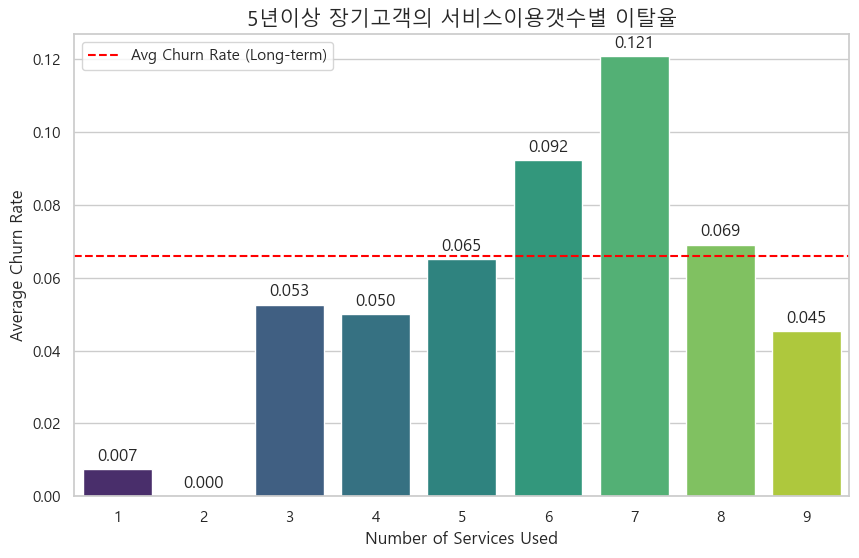

In [277]:
# 1. 5년 이상(60개월 초과) 장기 고객 데이터 필터링
long_term_customers = df[df['tenure'] > 60].copy()

# 2. 서비스 개수(ServiceCount)별 이탈률 계산
service_churn_longterm = long_term_customers.groupby('ServiceCount')['Churn_Numeric'].mean().reset_index()

# 3. 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ServiceCount', y='Churn_Numeric', data=service_churn_longterm, palette='viridis')

# 막대 위에 이탈률 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('5년이상 장기고객의 서비스이용갯수별 이탈율', fontsize=15)
plt.xlabel('Number of Services Used')
plt.ylabel('Average Churn Rate')
plt.axhline(long_term_customers['Churn_Numeric'].mean(), color='red', linestyle='--', label='Avg Churn Rate (Long-term)')
plt.legend()
plt.show()

In [278]:
# 1. 모든 서비스 관련 컬럼 리스트 (총 9개)
all_services = [
    'PhoneService', 'MultipleLines', 'InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# 2. 서비스 이용 개수 계산
# InternetService는 'No'가 아니면 이용하는 것으로 간주하고, 나머지는 'Yes'인 경우만 카운트
def count_total_services(row):
    count = 0
    # 전화 서비스 체크
    if row['PhoneService'] == 'Yes': count += 1
    if row['MultipleLines'] == 'Yes': count += 1
    # 인터넷 서비스 종류 체크 (DSL이나 Fiber optic이면 이용 중)
    if row['InternetService'] in ['DSL', 'Fiber optic']: count += 1
    # 부가 서비스 체크
    extra_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                      'TechSupport', 'StreamingTV', 'StreamingMovies']
    for s in extra_services:
        if row[s] == 'Yes':
            count += 1
    return count

df['TotalServiceCount'] = df.apply(count_total_services, axis=1)

# 3. 5년(60개월) 이상 장기 고객만 추출해서 분석
long_term = df[df['tenure'] >= 60].copy()
result = long_term.groupby('TotalServiceCount').agg({
    'Churn': lambda x: (x == 'Yes').mean() * 100,
    'MonthlyCharges': 'mean',
    'customerID': 'count'
}).rename(columns={'Churn': 'ChurnRate(%)', 'customerID': 'CustomerCount'})

print("--- 5년 이상 장기 고객의 전수 서비스 분석 ---")
display(result)

--- 5년 이상 장기 고객의 전수 서비스 분석 ---


,ChurnRate(%),MonthlyCharges,CustomerCount
TotalServiceCount,,,
1,0.694444,19.939583,144
2,0.000000,25.329252,147
3,5.000000,52.095000,20
4,5.797101,59.392754,69
5,7.462687,71.504851,134
6,8.810573,82.611013,227
7,12.179487,92.699840,312
8,6.772908,98.805179,251
9,4.469274,104.507821,179


C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\2348108445.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ServiceCount', y='MonthlyCharges', data=summary_df, ax=ax1, alpha=0.6, palette='Blues')


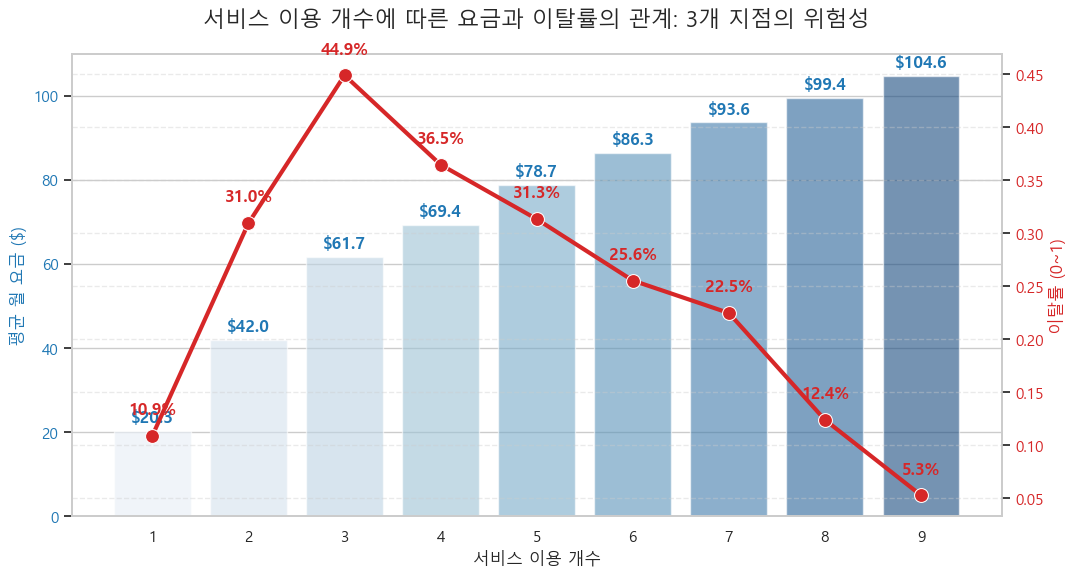

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 집계
summary_df = df.groupby('ServiceCount').agg({
    'MonthlyCharges': 'mean',
    'Churn_Numeric': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 1. 평균 요금 (막대 그래프)
sns.barplot(x='ServiceCount', y='MonthlyCharges', data=summary_df, ax=ax1, alpha=0.6, palette='Blues')
ax1.set_ylabel('평균 월 요금 ($)', fontsize=12, color='tab:blue')
ax1.set_xlabel('서비스 이용 개수', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 막대 위에 요금 수치 표시
for i, v in enumerate(summary_df['MonthlyCharges']):
    ax1.text(i, v + 2, f'${v:.1f}', ha='center', color='tab:blue', fontweight='bold')

# 2. 이탈률 (꺾은선 그래프) - 축 공유
ax2 = ax1.twinx()
sns.lineplot(x=range(len(summary_df)), y=summary_df['Churn_Numeric'], ax=ax2, color='tab:red', marker='o', linewidth=3, markersize=10)
ax2.set_ylabel('이탈률 (0~1)', fontsize=12, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 이탈률 수치 표시 (%)
for i, v in enumerate(summary_df['Churn_Numeric']):
    ax2.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', color='tab:red', fontweight='bold')

# 제목 설정 (한글)
plt.title('서비스 이용 개수에 따른 요금과 이탈률의 관계: 3개 지점의 위험성', fontsize=16, pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\1065610942.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ServiceCount', data=df, palette='viridis')


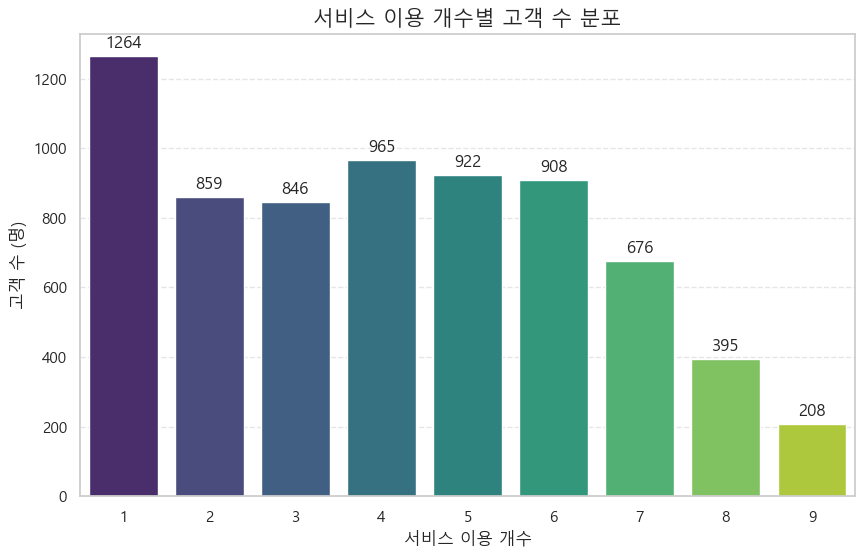

--- 서비스 개수별 비중 ---
ServiceCount
1    17.946898
2    12.196507
3    12.011927
4    13.701548
5    13.091012
6    12.892233
7     9.598183
8     5.608406
9     2.953287
Name: proportion, dtype: float64


In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서비스 개수별 가입자 수 집계
service_counts = df['ServiceCount'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ServiceCount', data=df, palette='viridis')

# 막대 위에 가입자 수 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

plt.title('서비스 이용 개수별 고객 수 분포', fontsize=15)
plt.xlabel('서비스 이용 개수')
plt.ylabel('고객 수 (명)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 비율로도 확인
print("--- 서비스 개수별 비중 ---")
print(df['ServiceCount'].value_counts(normalize=True).sort_index() * 100)

C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\3048791458.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='Churn_binary', data=df, palette='muted', errorbar=None)


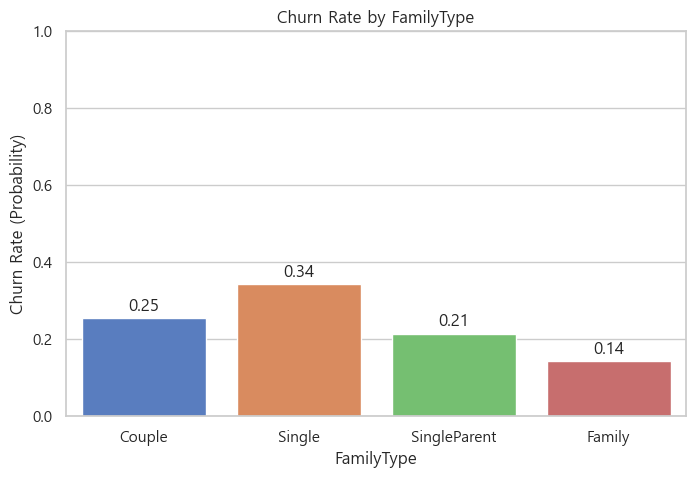

In [281]:
# 가족 결합 여부 (Family Type) 
# Partner(배우자)와 Dependents(부양가족) 정보를 결합
def family_type(row):
    if row['Partner'] == 'Yes' and row['Dependents'] == 'Yes':
        return 'Family'       # 배우자 O, 부양가족 O
    elif row['Partner'] == 'Yes' and row['Dependents'] == 'No':
        return 'Couple'       # 배우자 O, 부양가족 X
    elif row['Partner'] == 'No' and row['Dependents'] == 'Yes':
        return 'SingleParent' # 배우자 X, 부양가족 O
    else:
        return 'Single'       # 1인 가구

df['FamilyType'] = df.apply(family_type, axis=1)

# 가족 형태별 이탈률 확인 (보통 1인 가구가 이탈률이 높습니다)
plot_churn_rate('FamilyType')

1. **서비스 가입 개수**
* 서비스 가입 개수에 따라 보이는 이탈률은 **종형**에 가까운 형태를 보이고 있다.
	* **서비스 1개 그룹** : 월 요금 부담이 적어 번거롭게 통신사를 옮길 강력한 동기가 없다. 따라서 이탈이 적음
	* **서비스 3~5개 그룹** : 이탈률이 급격히 높아지는데, 이는 TV나 영화 스트리밍 등의 서비스를 추가하기 시작하는 단계인데, 월 요금을 대폭 상승 시킨다. 스트리밍 서비스가 고객을 붙잡는 힘이 강하지 않기 때문으로 추정
	* **서비스 6개 이상 그룹** : 단순 스트리밍 서비스 뿐만 아니라 보안, 보호, 기술 지원 등의 **관리형 서비스**를 받기 때문에 높은 요금으로 인한 부담보다 해지 시 겪게 될 불편함이 더 커 다시 이탈률이 낮아지는 것으로 보인다.
* **장기 고객군에서의 특이점**
	* 전체적으로는 서비스 다수 이용자가 충성도가 높으나, 5년 이상 장기 고객군에서는 서비스 7개 이용 시 이탈률이 급증하는 **역설적 구간**이 발견됨. 이는 과도한 요금 부담이나 구형 상품 결합의 한계로 해석된다.

2. **가입 기간**
* 써봤는데 별로네? 하고 나가는 경우일 것으로 추정.
* 해당 시기에 높은 초기 비용을 가질수록 이탈이 커진다. -> 비용 대비 가치가 낮다고 판단할 가능성이 있다.
* 신규 가입자의 이탈이 월 요금이 낮은 경우엔 적게 나타나는데, 신규 가입자 프로모션 등을 진행하여 월 요금을 낮춰 초기 이탈을 방지했을 것으로 추측됨.
* 월 단위 계약자 보다 2년 단위의 계약 고객의 서비스 이용 수가 높은데, 구독하는 서비스 종류가 많아질수록 장기 계약을 맺을 가능성이 크다고 판단된다.

3. **거래 방식**
* electronic check : 계좌 번호 입력, 수동 결제가 더 많이 이탈함
* credit card(automatic), bank transter(automatic)이 자동이체라 이탈이 적음
* **매달 직접 고지서를 확인하고 결제하는 행위**는 고객에게 서비스 이탈을 고민하는 기회를 제공

4. **인터넷서비스 유형**
* DSL과 나머지보다 fiber optic이 압도적으로 이탈률이 높다. (DSL의 2배 보다 큰 42%를 차지함)
* 광랜의 높은 요금이 고객 만족도를 저해하고 있거나, 안정성 이슈가 있을 수 있음. -> 모델링 시 월간요금이 높은 사용자 중, 광랜 이용자 들을 변수로 선정

5. **나이에 따른 이탈률 차이**
* 고령자가 더 이탈이 많은데, 다음과 같은 이유가 있다.
	* 거래 방식 중, electronic check의 비율이 52%로, 높다.
	* 월 단위 계약자가 많다. -> 월 단위 계약은 장기 계약보다 기본 요금이 비싸기 때문에, 부담 임계치를 넘으면 쉽게 이탈함.

6. **가족 형태**
* 1인 가구 형태에서 이탈률이 가장 크고, 다인 가구 일수록 줄어든다.
	* 경제적 이유 : 가족 결합의 경우 인터넷 + TV + 구성원 수 만큼의 회선 등 모두 엮여 있음
	* 해지 시 손실 : 결합 할인 등을 받은 고객일 가능성이 높고, 이탈하는 손간 통신비가 급등하게 된다.
	* 의사 결정권자 수 차이 : 여러 사람의 요구 사항을 맞춰야 하기 때문에, 적당히 만족하며 유지하는 성향이 강해진다.
 

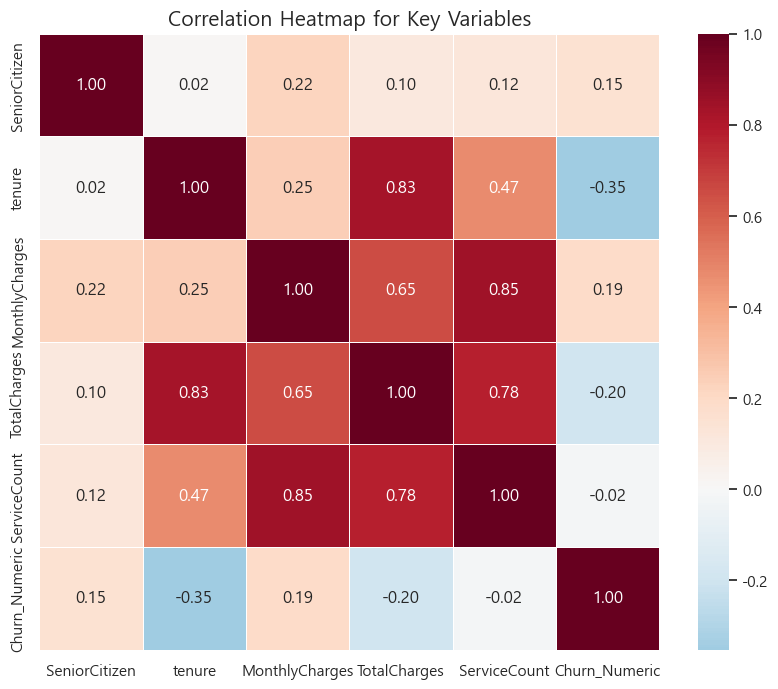

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 상관계수 계산을 위해 수치형 변수들만 선택
# 'TotalCharges'는 로드 시 문자열일 수 있으므로 다시 한번 숫자 변환
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 분석에 사용할 주요 수치형 및 인코딩된 변수 선택
cols_for_corr = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                 'ServiceCount', 'Churn_Numeric']

# 2. 상관계수 행렬 생성
corr_matrix = df[cols_for_corr].corr()

# 3. 히트맵 그리기
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # 상단 삼각형 가리기 (중복 제거)

sns.heatmap(corr_matrix, 
            annot=True,      # 수치 표시
            fmt=".2f",      # 소수점 둘째자리까지
            cmap='RdBu_r',  # 붉은색(양의 상관), 푸른색(음의 상관)
            center=0, 
            linewidths=0.5)

plt.title('Correlation Heatmap for Key Variables', fontsize=15)
plt.show()

In [283]:
# 0. 전처리: TotalCharges 수치화 및 서비스 개수 계산 (사전 준비)
all_services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServiceCount'] = (df[all_services] == 'Yes').sum(axis=1) + (df['InternetService'] != 'No').astype(int)

# ---------------------------------------------------------
# 1. 가족 가중치 변수 (Family_Stickiness)
# 가족이 있고 서비스를 많이 쓸수록 '이탈하기 힘든 족쇄'가 강해짐을 의미
# ---------------------------------------------------------
df['IsFamily'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)
df['Family_Stickiness'] = df['IsFamily'] * df['TotalServiceCount']


# ---------------------------------------------------------
# 2. 장기 고객 역설 변수 (LongTerm_Complexity_Risk)
# 60개월 이상 장기 고객이 서비스 7개 이상일 때 발생하는 이탈 위험을 수치화
# ---------------------------------------------------------
def get_longterm_risk(row):
    if row['tenure'] >= 60 and row['TotalServiceCount'] >= 7:
        return 1  # 고위험군 (역설적 이탈 구간)
    return 0

df['LongTerm_Complexity_Risk'] = df.apply(get_longterm_risk, axis=1)


# ---------------------------------------------------------
# 3. 광랜 사용자 최적화 변수 (Fiber_Price_Impact)
# 광랜(Fiber optic) 사용자이면서 월 요금이 평균보다 높은 경우의 부담감을 표현
# ---------------------------------------------------------
fiber_avg_bill = df[df['InternetService'] == 'Fiber optic']['MonthlyCharges'].mean()
df['Fiber_Price_Impact'] = df.apply(
    lambda x: x['MonthlyCharges'] if x['InternetService'] == 'Fiber optic' else 0, 
    axis=1
)
# 평균 대비 얼마나 더 내고 있는가? (광랜 사용자만 해당)
df['Fiber_Premium_Ratio'] = df.apply(
    lambda x: x['MonthlyCharges'] / fiber_avg_bill if x['InternetService'] == 'Fiber optic' else 0,
    axis=1
)

print("신규 변수 생성 완료!")
display(df[['Family_Stickiness', 'LongTerm_Complexity_Risk', 'Fiber_Premium_Ratio']].head())

신규 변수 생성 완료!


,Family_Stickiness,LongTerm_Complexity_Risk,Fiber_Premium_Ratio
0,2,0,0.000000
1,0,0,0.000000
2,0,0,0.000000
3,0,0,0.000000
4,0,0,0.772677


In [284]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Churn_binary,TenureGroup,ServiceCount,TotalServiceCount,FamilyType,IsFamily,Family_Stickiness,LongTerm_Complexity_Risk,Fiber_Price_Impact,Fiber_Premium_Ratio
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,0,1년 이하,2,2,Couple,1,2,0,0.0,0.000000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0,3년 이하,4,4,Single,0,0,0,0.0,0.000000
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,1,1년 이하,4,4,Single,0,0,0,0.0,0.000000
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,0,4년 이하,4,4,Single,0,0,0,0.0,0.000000
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,1,1년 이하,2,2,Single,0,0,0,70.7,0.772677


# 데이터 분할
모델 학습 및 평가, 그리고 최종 submission 생성을 위해 데이터를 분할합니다.
제출 파일 생성을 위한 별도의 test 파일이 없으므로, 전체 데이터의 20%를 test set(hold-out)으로 분리하여 사용합니다.

In [285]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")

Train shape: (5634, 30), Test shape: (1409, 30)


# 5. 모델링 (Modeling with AutoGluon)
AutoGluon의 TabularPredictor를 사용하여 학습합니다.

In [295]:
# 1. 훈련에 사용할 데이터 복사
train_data = df.copy()

# 2. [중요] 데이터 누수(Leakage) 방지: 정답 유출 컬럼 제거
# 타겟인 'Churn'은 남겨두고, 우리가 전처리나 분석용으로 만든 Churn_binary는 삭제합니다.
drop_cols = ['Churn_binary'] # ID와 중복 정답 컬럼 제거
train_data = train_data.drop(columns=drop_cols)

# label='Churn'으로 지정하면 AutoGluon이 알아서 Churn을 타겟으로 잡고 학습합니다.
predictor = TabularPredictor(
    label='Churn', 
    eval_metric='roc_auc' # 시니어가 강조한 AUC를 평가지표로 설정
).fit(
    train_data,
    presets='best_quality',
    time_limit=600 # 더 정확한 모델을 위해 설정 (시간이 조금 더 걸릴 수 있음)
)

No path specified. Models will be saved in: "AutogluonModels\ag-20260209_080330"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          6
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       18.91 GB / 31.92 GB (59.2%)
Disk Space Avail:   198.62 GB / 465.19 GB (42.7%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	

# 6. 앙상블 (Ensemble) 및 모델 비교 평가
AutoGluon은 `best_quality` 프리셋에서 자동으로 앙상블 모델(WeightedEnsemble)을 생성합니다.

In [296]:
# 리더보드 확인
leaderboard = predictor.leaderboard(test_data)
display(leaderboard)

# 성능 평가
perf = predictor.evaluate(test_data)
print("Performance on Test Data:")
print(perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr_BAG_L1,0.999873,0.818507,roc_auc,0.190047,0.548045,1.908106,0.190047,0.548045,1.908106,1,True,7
1,ExtraTreesGini_BAG_L1,0.999850,0.817795,roc_auc,0.199415,0.520109,1.534829,0.199415,0.520109,1.534829,1,True,6
2,RandomForestGini_BAG_L1,0.999840,0.822508,roc_auc,0.168118,0.392672,1.717241,0.168118,0.392672,1.717241,1,True,3
3,RandomForestEntr_BAG_L1,0.999840,0.824389,roc_auc,0.160632,0.346139,1.677467,0.160632,0.346139,1.677467,1,True,4
4,LightGBMLarge_BAG_L1,0.964676,0.835954,roc_auc,0.094241,0.090522,8.534902,0.094241,0.090522,8.534902,1,True,11
5,XGBoost_BAG_L1,0.902781,0.843383,roc_auc,0.164974,0.124237,8.163604,0.164974,0.124237,8.163604,1,True,9
6,LightGBM_BAG_L1,0.898291,0.844440,roc_auc,0.061132,0.088109,14.071640,0.061132,0.088109,14.071640,1,True,2
7,LightGBMXT_BAG_L1,0.882215,0.845932,roc_auc,0.182816,0.110772,9.509737,0.182816,0.110772,9.509737,1,True,1
8,WeightedEnsemble_L2,0.877984,0.850605,roc_auc,0.951689,1.540598,313.615304,0.002992,0.001995,0.307557,2,True,13
9,CatBoost_r177_BAG_L1,0.876463,0.847836,roc_auc,0.031434,0.095876,11.120295,0.031434,0.095876,11.120295,1,True,12


Performance on Test Data:
{'roc_auc': np.float64(0.8779844480611745), 'accuracy': 0.8211497515968772, 'balanced_accuracy': np.float64(0.7356751659820713), 'mcc': 0.513489752514114, 'f1': 0.6216216216216216, 'precision': 0.708904109589041, 'recall': 0.553475935828877}


In [297]:
predictor.evaluate(test_data)['roc_auc']

np.float64(0.8779844480611745)

In [298]:
importance = predictor.feature_importance(test_data)
display(importance.head(5))

These features in provided data are not utilized by the predictor and will be ignored: ['Churn_binary', 'TotalServiceCount']
Computing feature importance via permutation shuffling for 27 features using 1409 rows with 5 shuffle sets...
	112.07s	= Expected runtime (22.41s per shuffle set)
	43.24s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Contract,0.053915,0.004835,0.000008,5,0.063870,0.043959
tenure,0.045985,0.004715,0.000013,5,0.055693,0.036278
TotalCharges,0.013587,0.001913,0.000046,5,0.017525,0.009648
Fiber_Price_Impact,0.010425,0.001945,0.000139,5,0.014431,0.006420
PaymentMethod,0.006849,0.000862,0.000029,5,0.008624,0.005075


These features in provided data are not utilized by the predictor and will be ignored: ['Churn_binary', 'TotalServiceCount']
Computing feature importance via permutation shuffling for 27 features using 1409 rows with 5 shuffle sets...
	101.07s	= Expected runtime (20.21s per shuffle set)
	48.71s	= Actual runtime (Completed 5 of 5 shuffle sets)


--- Feature Importance Top 15 ---


,importance,stddev,p_value,n,p99_high,p99_low
Contract,0.053915,0.004835,0.000008,5,0.063870,0.043959
tenure,0.045985,0.004715,0.000013,5,0.055693,0.036278
TotalCharges,0.013587,0.001913,0.000046,5,0.017525,0.009648
Fiber_Price_Impact,0.010425,0.001945,0.000139,5,0.014431,0.006420
PaymentMethod,0.006849,0.000862,0.000029,5,0.008624,0.005075
MonthlyCharges,0.005503,0.001042,0.000147,5,0.007649,0.003357
Fiber_Premium_Ratio,0.005182,0.001638,0.001053,5,0.008554,0.001810
PaperlessBilling,0.005047,0.002091,0.002852,5,0.009352,0.000741
OnlineSecurity,0.004514,0.001196,0.000540,5,0.006977,0.002051
TechSupport,0.004113,0.001629,0.002425,5,0.007467,0.000758


C:\Users\zxcv5\AppData\Local\Temp\ipykernel_22408\1845556824.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y=importance.index, data=importance.reset_index(), palette='magma')


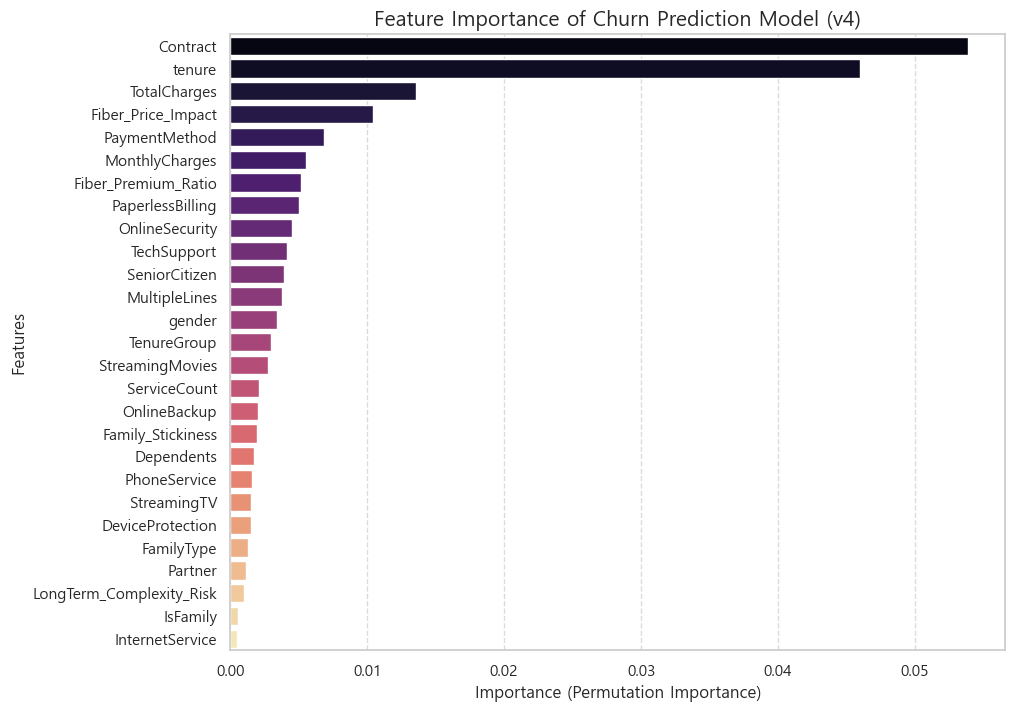

In [299]:
# 1. 변수 중요도 데이터 추출
# test_data를 넣으면 모델이 예측할 때 어떤 변수에 의존했는지 계산합니다.
importance = predictor.feature_importance(test_data)

# 2. 결과 출력 (상위 15개)
print("--- Feature Importance Top 15 ---")
display(importance.head(15))

# 3. 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=importance.index, data=importance.reset_index(), palette='magma')

plt.title('Feature Importance of Churn Prediction Model (v4)', fontsize=15)
plt.xlabel('Importance (Permutation Importance)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 7. submission.csv 파일 생성
테스트 데이터(Hold-out set)에 대한 예측 결과를 저장합니다.

In [300]:
# 예측 (확률 포함)
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)

# 결과 데이터프레임 생성
submission = pd.DataFrame({
    'Actual': test_data['Churn'],
    'Predicted': y_pred,
    'Probability_Yes': y_pred_proba.iloc[:, 1]  # 'Yes' 클래스 확률
})

# 파일 저장
submission.to_csv('submission_autogluon5.csv', index=False)
print("submission_autogluon5.csv file generated.")
display(submission.head())

submission_autogluon5.csv file generated.


,Actual,Predicted,Probability_Yes
437,No,No,0.045547
2280,No,Yes,0.752552
2235,No,No,0.064878
4460,No,No,0.286838
3761,No,No,0.020085
